In [217]:
import seaborn as sns  
from scipy.stats import pearsonr  
import folium # map rendering library
import json 
import numpy as np
import pandas as pd
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup

### IBM Applied Data Science Capstone Project  



### Introduction

According to restaurantscanada.org, 2020 would witness commercial foodservice sales improvement by 4%. Alberta and Ontario will lead the way with 4.4% and 4.2% growth, respectively. By 2021, foodservice sales are forecasted to go over 100-billion dollar.

The restaurant industry represents 4% of Canada GDP, with around 85 Billon dollars in annual sales that are generated by the
restaurant industry, it employs 1.2 Million people not less than 7% of the country total workforce. These figures could seem a bit staggering but when we put them in the context of Canadians making, on a daily basis, 22 Million visits to restaurants, it may completely change our perception of the restaurant business outlook.

Toronto, being the capital of Ontario, and having by far the biggest population and strongest economy within the province. Being a cosmopolitan metropole it fosters diverse culinary backgrounds when it comes to food businesses, catering and, restaurants and  attracting a huge number of immigrants makes its restaurant business a blooming one.

### Business Problem

This project objective is to come up with an analysis of the restaurant business in Toronto based on several features or characteristics such as population levels, income ranges, restaurant business categories, geolocation within the city and so on.  In other words, data science methology will allow to answer the following question:  Within the city of Toronto, where would be the best location to invest in a restaurant business and also for a given area within the city, what would best category of restaurant to invest on.

### Target Audience

The target audience of this project are potential restaurant business investors or restaurant managers who need to conduct a market research in order to get specific insights and be able to determine the business arguments to invest in a given category of food establishment within a specific area with a unique set of characteristics. This project being specific to the city of Toronto aims to provide a more targeted view than reports or studies related to Canada, and would help anyone interested in investing in this sector within Toronto.

### Data acquisition

#### Data Sources

1- “List of Postal code of Canada: M” (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) this wikipedia page provides the exhaustive list of Toronto postal codes or FSA, with their corresponding boroughs and neighborhoods. 

2- “https://cocl.us/Geospatial_data” this CSV file provides the longitude and latitudes of the Toronto FSA or postal codes.

3-  https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm - This repository from  Statistics Canada, provides a boundary file representing the FSAs of Canada, this file is in Shape format.  A conversion is to be conducted  to transform this file to GeoJSON format using QGIS software - please note that a reduction of the file has been conducted to keep only Toronto FSA with the GeoJSON file.

4- https://www.canada.ca/en/revenue-agency/programs/about-canada-revenue-agency-cra/income-statistics-gst-hst-statistics/individual-tax-statistics-fsa/individual-tax-statistics-fsa-2017-edition-2015-tax-year.html#t this page of the  Government of Canada,  provides the Individual Tax Statistics by Forward Sortation Area (FSA) − 2017 Edition, this CSV dataset will provide us with income inputs, this will be one of the features of our analysis and machine learning algorithm.  

5- https://www12.statcan.gc.ca/ Statistics Canada provides a CSV file of the 2016 population census, the population level feature will be assessed to see whether it has an incidence on the restaurant business in Toronto.

6- https://developer.foursquare.com/docs/api/endpoints: Restaurant businesses category related data is retrieved via the Foursquare API, this category is identified within Foursquare database with the following ID 4d4b7105d754a06374d81259 (https://developer.foursquare.com/docs). An HTTP request will be sent to the API as follows: GET https://api.foursquare.com/v2/venues/search, it will return a list of venues, matching our category ID, near the specified location (providing its latitude and longitude).



### Toronto FSA Data Webscraping 

In [218]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source= requests.get(url).text
soup=BeautifulSoup(source,'lxml')

In [219]:
table=soup.find('table')
table_headlines=[]

#Gets the table headlines 
for th in table.find_all('th') :
    #print(th.text.strip())
    table_headlines.append(th.text.strip())
    #print(ths)
    
data=[]
data_row=[]
# get the table data
for row in table.find_all('tr'):
    
    for item in row.find_all('td'):
        
        data_row.append(item.text.strip())
        
    data.append(data_row)
    data_row=[]
#print(data[1:])#print(data)
data=data[1:]   


We then create a pandas dataframe out of the extracted data

In [220]:
fsa_toronto = pd.DataFrame(data,columns=table_headlines) 

# Let's do some cleanup, by removing rows of  Boroughs with not assigned values 
fsa_toronto=fsa_toronto[fsa_toronto['Borough']!='Not assigned']
fsa_toronto['Borough'].value_counts()
fsa_toronto.shape

(103, 3)

In [221]:
fsa_toronto.head()

Postal code           Borough                                  Neighborhood
2         M3A        North York                                     Parkwoods
3         M4A        North York                              Victoria Village
4         M5A  Downtown Toronto                    Regent Park / Harbourfront
5         M6A        North York             Lawrence Manor / Lawrence Heights
6         M7A  Downtown Toronto  Queen's Park / Ontario Provincial Government

Let's perform some data aggregation to remove Postcode and Borough redundant entries

In [222]:
fsa_toronto=fsa_toronto.groupby(['Postal code','Borough'])['Neighborhood'].apply(','.join).reset_index() 
fsa_toronto.rename(columns={'Postal code':'Postcode'},inplace=True)
fsa_toronto.head(103)

Postcode      Borough                                       Neighborhood
0        M1B  Scarborough                                    Malvern / Rouge
1        M1C  Scarborough           Rouge Hill / Port Union / Highland Creek
2        M1E  Scarborough                Guildwood / Morningside / West Hill
3        M1G  Scarborough                                             Woburn
4        M1H  Scarborough                                          Cedarbrae
..       ...          ...                                                ...
98       M9N         York                                             Weston
99       M9P    Etobicoke                                          Westmount
100      M9R    Etobicoke  Kingsview Village / St. Phillips / Martin Grov...
101      M9V    Etobicoke  South Steeles / Silverstone / Humbergate / Jam...
102      M9W    Etobicoke                                          Northwest

[103 rows x 3 columns]

Toronto Borough&Neighbourhood dataframe is ready to be saved

In [223]:
fsa_toronto.to_csv(r'fsa_toronto.csv',index=False,header=True)

### Toronto FSA Geo Tagging

let's retrieve the geo data from "https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv"

In [224]:
url = "https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv"
geo_toronto=pd.read_csv(url)
geo_toronto.rename(columns={'Postal Code':'Postcode'},inplace=True)
geo_toronto.head(103)

Postcode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476
..       ...        ...        ...
98       M9N  43.706876 -79.518188
99       M9P  43.696319 -79.532242
100      M9R  43.688905 -79.554724
101      M9V  43.739416 -79.588437
102      M9W  43.706748 -79.594054

[103 rows x 3 columns]

let's merge this data with the Toronto Borough and Neighborhoods data

In [225]:
toronto_combined_data=pd.merge(fsa_toronto,geo_toronto,left_on="Postcode",right_on="Postcode",how="inner")
toronto_combined_data.rename(columns={'Neighborhood':'Neighbourhood'},inplace=True)
toronto_combined_data.head()

Postcode      Borough                             Neighbourhood   Latitude  \
0      M1B  Scarborough                           Malvern / Rouge  43.806686   
1      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek  43.784535   
2      M1E  Scarborough       Guildwood / Morningside / West Hill  43.763573   
3      M1G  Scarborough                                    Woburn  43.770992   
4      M1H  Scarborough                                 Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

### Toronto Population Data

#### Data Extraction

Extracting the toronto population data from a CSV file downloaded right from the 2016 Census statistics official website

In [226]:
canada_population=pd.read_csv("T120120200322093044.CSV", encoding = "ISO-8859-1")
canada_population.drop(columns=['Geographic code','Province or territory',
'Incompletely enumerated Indian reserves and Indian settlements, 2016',
'Total private dwellings, 2016', 'Private dwellings occupied by usual residents, 2016'],inplace=True)
canada_population.shape
canada_population.head()

Geographic name  Population, 2016
0          Canada        35151728.0
1             A0A           46587.0
2             A0B           19792.0
3             A0C           12587.0
4             A0E           22294.0

Let's enrich this dataframe with the geo data we gathered previously (Neighbourhoods, Geo data) 

In [227]:
toronto_combined_data=pd.merge(toronto_combined_data,canada_population,left_on="Postcode",right_on="Geographic name",how="left")
toronto_combined_data.drop(columns=["Geographic name"],inplace=True)
toronto_combined_data.shape

(103, 6)

In [228]:
toronto_combined_data.head()

Postcode      Borough                             Neighbourhood   Latitude  \
0      M1B  Scarborough                           Malvern / Rouge  43.806686   
1      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek  43.784535   
2      M1E  Scarborough       Guildwood / Morningside / West Hill  43.763573   
3      M1G  Scarborough                                    Woburn  43.770992   
4      M1H  Scarborough                                 Cedarbrae  43.773136   

   Longitude  Population, 2016  
0 -79.194353           66108.0  
1 -79.160497           35626.0  
2 -79.188711           46943.0  
3 -79.216917           29690.0  
4 -79.239476           24383.0

#### Data Cleanup

let's check after the data merge for inconsistent values

In [229]:
toronto_combined_data.isna().sum()

Postcode            0
Borough             0
Neighbourhood       0
Latitude            0
Longitude           0
Population, 2016    1
dtype: int64

Indeed there are... let us do some cleanup

In [230]:
toronto_combined_data.fillna(0,inplace=True)

In [231]:
toronto_combined_data.isna().sum()

Postcode            0
Borough             0
Neighbourhood       0
Latitude            0
Longitude           0
Population, 2016    0
dtype: int64

Here we go!

In [232]:
toronto_combined_data.head()

Postcode      Borough                             Neighbourhood   Latitude  \
0      M1B  Scarborough                           Malvern / Rouge  43.806686   
1      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek  43.784535   
2      M1E  Scarborough       Guildwood / Morningside / West Hill  43.763573   
3      M1G  Scarborough                                    Woburn  43.770992   
4      M1H  Scarborough                                 Cedarbrae  43.773136   

   Longitude  Population, 2016  
0 -79.194353           66108.0  
1 -79.160497           35626.0  
2 -79.188711           46943.0  
3 -79.216917           29690.0  
4 -79.239476           24383.0

For the sake of a better data visualization, I have retreived a shape file from https://www12.statcan.gc.ca to depict the FSAs of Canada I have converted this shape file  to a GeoJSON file using QGIS and also I have applied a filter so that my geojson is only taking into consideration the Toronto FSAs (the Pandas dataframe has been very handy to provide the list of Toronto FSA).  The result of this operation is the toronto_FSA.geojson file, for the sake of testing let's draw a Toronto map and represent the population levels per FSA in Toronto. The link between Geojson file and our dataframe would be obviously the id of the postcode/FSA (in json it is represented by feature.properties.CFSAUID)

Let's map it! 

In [233]:
legend = np.linspace(toronto_combined_data['Population, 2016'].min(),
                              toronto_combined_data['Population, 2016'].max(),
                              6,dtype=int)
legend = legend.tolist()
#print(legend)

map_toronto = folium.Map(location=[43.653963, -79.387207], zoom_start=10)
ontario_geo = "toronto_FSA.geojson"
map_toronto.choropleth(geo_data=ontario_geo,
    data = toronto_combined_data,
    columns=['Postcode','Population, 2016'],
    key_on='feature.properties.CFSAUID',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,              
    legend_name='Population',
    threshold_scale=[0, 15000, 30000, 45000, 60000, 76000])   
    
map_toronto

### Toronto Income Data

#### Data Extraction

I will extract this data from the 2016 Census statistics dataset from www.canada.ca, in the form of a CSV file that will be loaded in a specific dataframe

In [234]:

toronto_income = pd.read_csv("tbl1b-en.csv", encoding = "ISO-8859-1")


In [235]:

toronto_income=toronto_income.iloc[:,:-2]
toronto_income.head()

Prov/Terr  FSA    Total  Total Income  Under $5,000  $5,000 to $9,999  \
0        10  A0A  40150.0  1.673931e+09        2950.0            2700.0   
1        10  A0B  17820.0  7.141520e+08        1180.0            1150.0   
2        10  A0C  11180.0  3.787120e+08         780.0             720.0   
3        10  A0E  19860.0  8.285010e+08        1520.0            1390.0   
4        10  A0G  31290.0  1.089500e+09        2510.0            1960.0   

   $10,000 to $14,999  $15,000 to $19,999  $20,000 to $24,999  \
0              3880.0              5220.0              3220.0   
1              1790.0              2570.0              1650.0   
2              1220.0              1870.0              1180.0   
3              2070.0              2850.0              1850.0   
4              3840.0              5040.0              2890.0   

   $25,000 to $29,999  ...  $45,000 to $49,999  $50,000 to $54,999  \
0              2770.0  ...              1600.0              1320.0   
1              1370.0  ...               710.0               580.0   
2               940.0  ...               440.0               300.0   
3              1400.0  ...               610.0               460.0   
4              2380.0  ...              1110.0               850.0   

   $55,000 to $59,999  $60,000 to $69,999  $70,000 to $79,999  \
0              1210.0              1700.0              1380.0   
1               480.0               710.0               520.0   
2               270.0               390.0               230.0   
3               450.0               710.0               610.0   
4               670.0              1060.0               780.0   

   $80,000 to $89,999  $90,000 to $99,999  $100,000 to $149,999  \
0              1150.0               960.0                2240.0   
1               420.0               340.0                 960.0   
2               200.0               180.0                 340.0   
3               580.0               530.0                1520.0   
4               690.0               510.0                1230.0   

   $150,000 to $249,999  $250,000 and over  
0                 880.0              170.0  
1                 380.0               60.0  
2                 110.0               10.0  
3                 460.0               60.0  
4                 340.0               70.0  

[5 rows x 23 columns]

#### Income Data Cleanup

Let's remove not needed data

In [236]:
toronto_income.drop(columns=["Prov/Terr"],inplace=True)

In [237]:
toronto_income.head()

FSA    Total  Total Income  Under $5,000  $5,000 to $9,999  \
0  A0A  40150.0  1.673931e+09        2950.0            2700.0   
1  A0B  17820.0  7.141520e+08        1180.0            1150.0   
2  A0C  11180.0  3.787120e+08         780.0             720.0   
3  A0E  19860.0  8.285010e+08        1520.0            1390.0   
4  A0G  31290.0  1.089500e+09        2510.0            1960.0   

   $10,000 to $14,999  $15,000 to $19,999  $20,000 to $24,999  \
0              3880.0              5220.0              3220.0   
1              1790.0              2570.0              1650.0   
2              1220.0              1870.0              1180.0   
3              2070.0              2850.0              1850.0   
4              3840.0              5040.0              2890.0   

   $25,000 to $29,999  $30,000 to $34,999  ...  $45,000 to $49,999  \
0              2770.0              2550.0  ...              1600.0   
1              1370.0              1130.0  ...               710.0   
2               940.0               840.0  ...               440.0   
3              1400.0              1140.0  ...               610.0   
4              2380.0              2180.0  ...              1110.0   

   $50,000 to $54,999  $55,000 to $59,999  $60,000 to $69,999  \
0              1320.0              1210.0              1700.0   
1               580.0               480.0               710.0   
2               300.0               270.0               390.0   
3               460.0               450.0               710.0   
4               850.0               670.0              1060.0   

   $70,000 to $79,999  $80,000 to $89,999  $90,000 to $99,999  \
0              1380.0              1150.0               960.0   
1               520.0               420.0               340.0   
2               230.0               200.0               180.0   
3               610.0               580.0               530.0   
4               780.0               690.0               510.0   

   $100,000 to $149,999  $150,000 to $249,999  $250,000 and over  
0                2240.0                 880.0              170.0  
1                 960.0                 380.0               60.0  
2                 340.0                 110.0               10.0  
3                1520.0                 460.0               60.0  
4                1230.0                 340.0               70.0  

[5 rows x 22 columns]

let's also reorder the columns sequence within our dataframe 

In [238]:

list_col=  [toronto_income.columns[0]] + [toronto_income.columns[2]] + [toronto_income.columns[1]] + list(toronto_income.columns[3:])  
print(list_col)
toronto_income=toronto_income[list_col]

['FSA', 'Total Income', 'Total', 'Under $5,000', '$5,000 to $9,999', '$10,000 to $14,999', '$15,000 to $19,999', '$20,000 to $24,999', '$25,000 to $29,999', '$30,000 to $34,999', '$35,000 to $39,999', '$40,000 to $44,999', '$45,000 to $49,999', '$50,000 to $54,999', '$55,000 to $59,999', '$60,000 to $69,999', '$70,000 to $79,999', '$80,000 to $89,999', '$90,000 to $99,999', '$100,000 to $149,999', '$150,000 to $249,999', '$250,000 and over']


and merge the income data with our global neighbourhood/postcode/population Toronto dataset  we have gathered so far, we will get rid of the income data not related to Toronto with this merge,  two birds, one stones:-)

In [239]:
# Select only Toronto data
#left join not to loose any FSA related information
toronto_combined_data=pd.merge(toronto_combined_data,toronto_income,left_on="Postcode",right_on="FSA",how="left")
toronto_combined_data.drop(columns=["FSA"],inplace=True)
toronto_combined_data.head()

Postcode      Borough                             Neighbourhood   Latitude  \
0      M1B  Scarborough                           Malvern / Rouge  43.806686   
1      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek  43.784535   
2      M1E  Scarborough       Guildwood / Morningside / West Hill  43.763573   
3      M1G  Scarborough                                    Woburn  43.770992   
4      M1H  Scarborough                                 Cedarbrae  43.773136   

   Longitude  Population, 2016  Total Income    Total  Under $5,000  \
0 -79.194353           66108.0  1.577233e+09  51410.0        8140.0   
1 -79.160497           35626.0  1.483624e+09  29080.0        3340.0   
2 -79.188711           46943.0  1.320927e+09  36220.0        4810.0   
3 -79.216917           29690.0  6.372060e+08  22820.0        4300.0   
4 -79.239476           24383.0  6.152230e+08  19440.0        3500.0   

   $5,000 to $9,999  ...  $45,000 to $49,999  $50,000 to $54,999  \
0            4340.0  ...              2280.0              1900.0   
1            1780.0  ...              1320.0              1200.0   
2            2970.0  ...              1550.0              1280.0   
3            2120.0  ...               860.0               640.0   
4            1510.0  ...               800.0               640.0   

   $55,000 to $59,999  $60,000 to $69,999  $70,000 to $79,999  \
0              1560.0              2290.0              1550.0   
1              1060.0              1850.0              1580.0   
2              1140.0              1730.0              1350.0   
3               540.0               800.0               610.0   
4               560.0               820.0               640.0   

   $80,000 to $89,999  $90,000 to $99,999  $100,000 to $149,999  \
0               920.0               720.0                1070.0   
1              1210.0              1200.0                2250.0   
2               930.0               840.0                1310.0   
3               400.0               280.0                 440.0   
4               420.0               330.0                 480.0   

   $150,000 to $249,999  $250,000 and over  
0                 200.0               40.0  
1                 770.0              270.0  
2                 390.0              140.0  
3                  80.0               20.0  
4                 130.0               30.0  

[5 rows x 27 columns]

Let's see if our data is clean by checking for any missing values within pur dataset

In [240]:
missing_data = toronto_combined_data.isnull()


Let's analyze the missing values to have a better idea on the course of cleanup actions to undertake 

In [241]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")    

Postcode
False    103
Name: Postcode, dtype: int64

Borough
False    103
Name: Borough, dtype: int64

Neighbourhood
False    103
Name: Neighbourhood, dtype: int64

Latitude
False    103
Name: Latitude, dtype: int64

Longitude
False    103
Name: Longitude, dtype: int64

Population, 2016
False    103
Name: Population, 2016, dtype: int64

Total Income
False    102
True       1
Name: Total Income, dtype: int64

Total
False    102
True       1
Name: Total, dtype: int64

Under $5,000
False    102
True       1
Name: Under $5,000, dtype: int64

$5,000 to $9,999
False    102
True       1
Name: $5,000 to $9,999, dtype: int64

$10,000 to $14,999
False    102
True       1
Name: $10,000 to $14,999, dtype: int64

$15,000 to $19,999
False    102
True       1
Name: $15,000 to $19,999, dtype: int64

$20,000 to $24,999
False    102
True       1
Name: $20,000 to $24,999, dtype: int64

$25,000 to $29,999
False    102
True       1
Name: $25,000 to $29,999, dtype: int64

$30,000 to $34,999
False    102
True

We have 1 missing value per column, not much, let's print out one of them to see how they look

In [242]:
toronto_combined_data[toronto_combined_data['Total Income'].isnull()]

Postcode      Borough                          Neighbourhood   Latitude  \
86      M7R  Mississauga  Canada Post Gateway Processing Centre  43.636966   

    Longitude  Population, 2016  Total Income  Total  Under $5,000  \
86 -79.615819               0.0           NaN    NaN           NaN   

    $5,000 to $9,999  ...  $45,000 to $49,999  $50,000 to $54,999  \
86               NaN  ...                 NaN                 NaN   

    $55,000 to $59,999  $60,000 to $69,999  $70,000 to $79,999  \
86                 NaN                 NaN                 NaN   

    $80,000 to $89,999  $90,000 to $99,999  $100,000 to $149,999  \
86                 NaN                 NaN                   NaN   

    $150,000 to $249,999  $250,000 and over  
86                   NaN                NaN  

[1 rows x 27 columns]

Bingo! we have only one FSA/postcode with missing income values, M7R which is related to Canada Post Gateway Processing Centre (Missisauga), let's replace its missing values by zeros.

In [243]:
toronto_combined_data.fillna(0, inplace = True)


In [244]:
toronto_combined_data.isna().sum()

Postcode                0
Borough                 0
Neighbourhood           0
Latitude                0
Longitude               0
Population, 2016        0
Total Income            0
Total                   0
Under $5,000            0
$5,000 to $9,999        0
$10,000 to $14,999      0
$15,000 to $19,999      0
$20,000 to $24,999      0
$25,000 to $29,999      0
$30,000 to $34,999      0
$35,000 to $39,999      0
$40,000 to $44,999      0
$45,000 to $49,999      0
$50,000 to $54,999      0
$55,000 to $59,999      0
$60,000 to $69,999      0
$70,000 to $79,999      0
$80,000 to $89,999      0
$90,000 to $99,999      0
$100,000 to $149,999    0
$150,000 to $249,999    0
$250,000 and over       0
dtype: int64

Let's do some data conversion

In [245]:
# Convert the income data to integers to have a plain total income column 
#toronto_income.iloc[:,0]=toronto_income.iloc[:,0].astype(str)

for col in toronto_combined_data.columns[7:]:
    toronto_combined_data[col]=toronto_combined_data[col].astype(int)
    
toronto_combined_data.dtypes

Postcode                 object
Borough                  object
Neighbourhood            object
Latitude                float64
Longitude               float64
Population, 2016        float64
Total Income            float64
Total                     int32
Under $5,000              int32
$5,000 to $9,999          int32
$10,000 to $14,999        int32
$15,000 to $19,999        int32
$20,000 to $24,999        int32
$25,000 to $29,999        int32
$30,000 to $34,999        int32
$35,000 to $39,999        int32
$40,000 to $44,999        int32
$45,000 to $49,999        int32
$50,000 to $54,999        int32
$55,000 to $59,999        int32
$60,000 to $69,999        int32
$70,000 to $79,999        int32
$80,000 to $89,999        int32
$90,000 to $99,999        int32
$100,000 to $149,999      int32
$150,000 to $249,999      int32
$250,000 and over         int32
dtype: object

In [246]:
toronto_combined_data.head()

Postcode      Borough                             Neighbourhood   Latitude  \
0      M1B  Scarborough                           Malvern / Rouge  43.806686   
1      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek  43.784535   
2      M1E  Scarborough       Guildwood / Morningside / West Hill  43.763573   
3      M1G  Scarborough                                    Woburn  43.770992   
4      M1H  Scarborough                                 Cedarbrae  43.773136   

   Longitude  Population, 2016  Total Income  Total  Under $5,000  \
0 -79.194353           66108.0  1.577233e+09  51410          8140   
1 -79.160497           35626.0  1.483624e+09  29080          3340   
2 -79.188711           46943.0  1.320927e+09  36220          4810   
3 -79.216917           29690.0  6.372060e+08  22820          4300   
4 -79.239476           24383.0  6.152230e+08  19440          3500   

   $5,000 to $9,999  ...  $45,000 to $49,999  $50,000 to $54,999  \
0              4340  ...                2280                1900   
1              1780  ...                1320                1200   
2              2970  ...                1550                1280   
3              2120  ...                 860                 640   
4              1510  ...                 800                 640   

   $55,000 to $59,999  $60,000 to $69,999  $70,000 to $79,999  \
0                1560                2290                1550   
1                1060                1850                1580   
2                1140                1730                1350   
3                 540                 800                 610   
4                 560                 820                 640   

   $80,000 to $89,999  $90,000 to $99,999  $100,000 to $149,999  \
0                 920                 720                  1070   
1                1210                1200                  2250   
2                 930                 840                  1310   
3                 400                 280                   440   
4                 420                 330                   480   

   $150,000 to $249,999  $250,000 and over  
0                   200                 40  
1                   770                270  
2                   390                140  
3                    80                 20  
4                   130                 30  

[5 rows x 27 columns]

In [247]:
toronto_income.sort_values('Total Income',ascending=False,inplace=True)
toronto_income.shape


(1999, 22)

Our Toronto income dataset is ready! let's plot it to check if there any left anomalies...

In [248]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.3


In [249]:
toronto_combined_data.head()

Postcode      Borough                             Neighbourhood   Latitude  \
0      M1B  Scarborough                           Malvern / Rouge  43.806686   
1      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek  43.784535   
2      M1E  Scarborough       Guildwood / Morningside / West Hill  43.763573   
3      M1G  Scarborough                                    Woburn  43.770992   
4      M1H  Scarborough                                 Cedarbrae  43.773136   

   Longitude  Population, 2016  Total Income  Total  Under $5,000  \
0 -79.194353           66108.0  1.577233e+09  51410          8140   
1 -79.160497           35626.0  1.483624e+09  29080          3340   
2 -79.188711           46943.0  1.320927e+09  36220          4810   
3 -79.216917           29690.0  6.372060e+08  22820          4300   
4 -79.239476           24383.0  6.152230e+08  19440          3500   

   $5,000 to $9,999  ...  $45,000 to $49,999  $50,000 to $54,999  \
0              4340  ...                2280                1900   
1              1780  ...                1320                1200   
2              2970  ...                1550                1280   
3              2120  ...                 860                 640   
4              1510  ...                 800                 640   

   $55,000 to $59,999  $60,000 to $69,999  $70,000 to $79,999  \
0                1560                2290                1550   
1                1060                1850                1580   
2                1140                1730                1350   
3                 540                 800                 610   
4                 560                 820                 640   

   $80,000 to $89,999  $90,000 to $99,999  $100,000 to $149,999  \
0                 920                 720                  1070   
1                1210                1200                  2250   
2                 930                 840                  1310   
3                 400                 280                   440   
4                 420                 330                   480   

   $150,000 to $249,999  $250,000 and over  
0                   200                 40  
1                   770                270  
2                   390                140  
3                    80                 20  
4                   130                 30  

[5 rows x 27 columns]

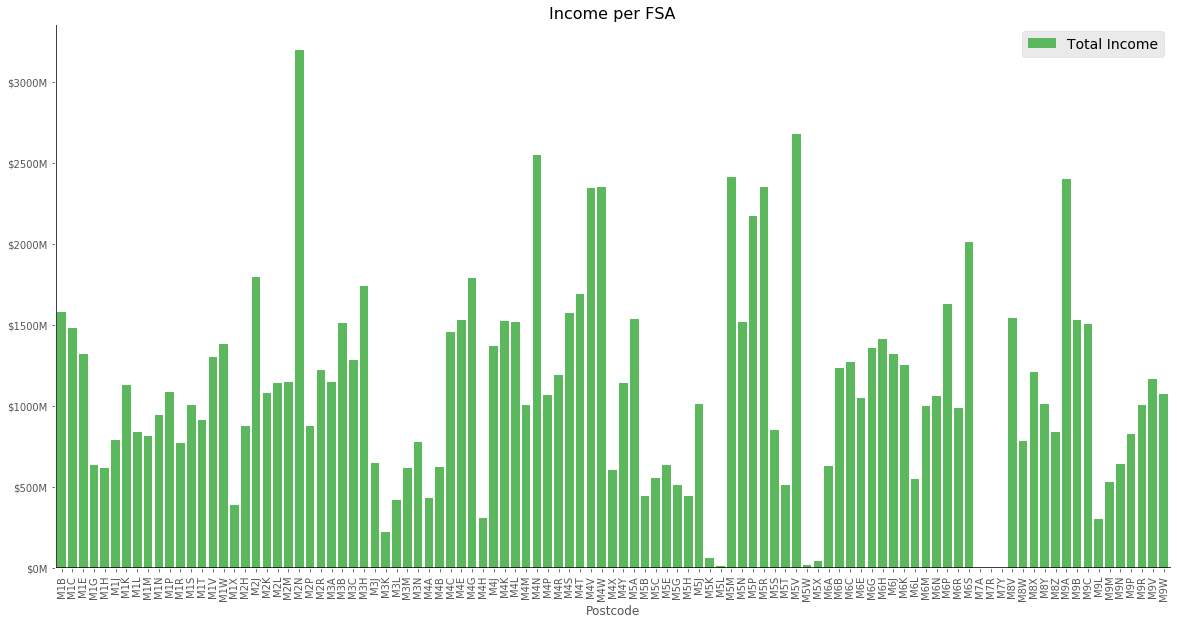

In [250]:
# let's plot the income 
graph_income_data=toronto_combined_data[['Postcode','Total Income']].set_index(['Postcode'])

# format the income from exp formatted float values to millions of dollars 
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fM' % (x * 1e-6) #removes the 0 after the dot

formatter = FuncFormatter(millions)
#fig, ax = plt.subplots()
ax=graph_income_data.plot(kind='bar', width=0.8, color=['#5cb85c','#5bc0de','#d9534f'], grid=False, figsize=(20,10))
# format the income values into Millions
ax.yaxis.set_major_formatter(formatter)
#Change the legend font size 
plt.legend( prop={"size":14})
#set the background color to white
ax.set_facecolor('white')
#draw the x axis
plt.axhline(0, color='black')
#draw the y axis
plt.axvline(-0.5, color='black')
#plot the graph title
plt.title('Income per FSA' , fontsize=16)
plt.show()

We are all set with the income data!

Plotting this data has shown me that mistakenly the 'Total Income' has been converted to integer and some values were negative, it is a good practise to visualize data not only to study it but also to check if the data extraction and cleanup went well

### Toronto Restaurants Data 

#### Data Extraction

The approach will be to retrieve all the venues of catering category type for each FSA/postcode via the Foursquare API.  

    1- First step is to get the catering category from the Foursquare documentation 

    2- Search all the venues of one test neighbourhood or FSA based on the catering category

    3- Retrieve for each FSA the catering venues

The catering category type is 4d4b7105d754a06374d81259 (Cf API documentation: https://developer.foursquare.com/docs/resources/categories)

In [251]:
print("The test neighbourhood is :",toronto_combined_data.loc[0,'Neighbourhood'])

The test neighbourhood is : Malvern / Rouge


Let's prepare the HTTP GET Request towards the API

In [252]:
CLIENT_ID = 'FZ2CDP4HVQ0PUEDNEAZDTJC0XQQINOTU5C5PYMYRJF1504YQ' # your Foursquare ID
CLIENT_SECRET = 'MYLQJWLMBQ3U4CH0ADX41EQDUM4FXF4GVJXDIN1NGOEKUUXK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [253]:
neighborhood_latitude = toronto_combined_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_combined_data.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = toronto_combined_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))
radius=500
LIMIT=100
categoryID='4d4b7105d754a06374d81259'

Latitude and longitude values of Malvern / Rouge are 43.806686299999996, -79.19435340000001.


In [254]:

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT,categoryID)
url

'https://api.foursquare.com/v2/venues/search?client_id=FZ2CDP4HVQ0PUEDNEAZDTJC0XQQINOTU5C5PYMYRJF1504YQ&client_secret=MYLQJWLMBQ3U4CH0ADX41EQDUM4FXF4GVJXDIN1NGOEKUUXK&ll=43.806686299999996,-79.19435340000001&v=20180605&radius=500&limit=100&categoryId=4d4b7105d754a06374d81259'

We launch the request to the API

In [255]:
results = requests.get(url).json()['response']['venues']
#venues=json_normalize(results['response']['venues'])

Let's parse the results and display relevant variables

In [256]:
# fill restaurant_list with all the food entries within the FSA specified in our HTTP GET request
catering_list=[]

for venue in results:
    catering_list.append([
        venue['name'],
        venue['location']['labeledLatLngs'][0]['lat'],
        venue['location']['labeledLatLngs'][0]['lng'],
        venue['categories'][0]['name']]
        )
print(catering_list)

[["Meena's Fine Foods", 43.80447575837742, -79.19975280761719, 'Indian Restaurant'], ['Wendy’s', 43.80744841934756, -79.19905558052072, 'Fast Food Restaurant'], ['Second Cup', 43.802164535542744, -79.19611362644378, 'Coffee Shop']]


And voila! let's proceed with our 2nd step, we will now search under the food category for all the venues for each of the Toronto neighbourhood (FSA)

In [257]:


# fill restaurant_list with all the food entries within the FSA specified in our HTTP GET request
catering_list=[]

for fsa,borough_name,neighborhood,borough_latitude,borough_longitude in zip(toronto_combined_data['Postcode'],toronto_combined_data['Borough'],toronto_combined_data['Neighbourhood'],toronto_combined_data['Latitude'],toronto_combined_data['Longitude']):
    #URL  for the HTTP GET request for a given Borough/FSA
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, borough_latitude, borough_longitude, VERSION, radius, LIMIT,categoryID)
    results = requests.get(url).json()['response']['venues']
    # Gets the list of catering places for a given borough/FSA
    for venue in results:
        catering_list.append([
            fsa,
            borough_name,
            neighborhood,
            venue['name'],
            venue['location']['labeledLatLngs'][0]['lat'],
            venue['location']['labeledLatLngs'][0]['lng'],
            venue['categories'][0]['name']]
            )

toronto_catering=pd.DataFrame(catering_list,columns=['Postcode', 'Borough', 'Neighbourhood','Catering Name','Latitude', 'Longitude','Category'])

In [258]:
toronto_catering.shape

(2364, 7)

Point 3 is done, We have now retrieved all needed catering data for Toronto thanks to the Foursquare API.

In [259]:
toronto_catering.head(100)

Postcode      Borough                                      Neighbourhood  \
0       M1B  Scarborough                                    Malvern / Rouge   
1       M1B  Scarborough                                    Malvern / Rouge   
2       M1B  Scarborough                                    Malvern / Rouge   
3       M1C  Scarborough           Rouge Hill / Port Union / Highland Creek   
4       M1C  Scarborough           Rouge Hill / Port Union / Highland Creek   
..      ...          ...                                                ...   
95      M1P  Scarborough  Dorset Park / Wexford Heights / Scarborough To...   
96      M1R  Scarborough                                 Wexford / Maryvale   
97      M1R  Scarborough                                 Wexford / Maryvale   
98      M1R  Scarborough                                 Wexford / Maryvale   
99      M1R  Scarborough                                 Wexford / Maryvale   

         Catering Name   Latitude  Longitude                   Category  
0   Meena's Fine Foods  43.804476 -79.199753          Indian Restaurant  
1              Wendy’s  43.807448 -79.199056       Fast Food Restaurant  
2           Second Cup  43.802165 -79.196114                Coffee Shop  
3     Shamrock Burgers  43.783823 -79.168406               Burger Joint  
4              Amigo's  43.783749 -79.168691             Breakfast Spot  
..                 ...        ...        ...                        ...  
95   Montmartre Bakery  43.754463 -79.267934                     Bakery  
96            FV Foods  43.745658 -79.292488           Asian Restaurant  
97         Tim Hortons  43.750140 -79.293139                Coffee Shop  
98      Crown Pastries  43.746098 -79.293142                     Bakery  
99     Lebanese bakery  43.746701 -79.292896  Middle Eastern Restaurant  

[100 rows x 7 columns]

In [260]:
toronto_catering.describe(include='all')

Postcode           Borough Neighbourhood Catering Name     Latitude  \
count      2364              2364          2364          2364  2364.000000   
unique       98                10            93          1637          NaN   
top         M5T  Downtown Toronto    Willowdale     Starbucks          NaN   
freq         50               830            53            91          NaN   
mean        NaN               NaN           NaN           NaN    43.684516   
std         NaN               NaN           NaN           NaN     0.046502   
min         NaN               NaN           NaN           NaN    43.598429   
25%         NaN               NaN           NaN           NaN    43.650046   
50%         NaN               NaN           NaN           NaN    43.666348   
75%         NaN               NaN           NaN           NaN    43.710029   
max         NaN               NaN           NaN           NaN    43.816136   

          Longitude     Category  
count   2364.000000         2364  
unique          NaN          141  
top             NaN  Coffee Shop  
freq            NaN          299  
mean     -79.392546          NaN  
std        0.072164          NaN  
min      -79.622110          NaN  
25%      -79.419832          NaN  
50%      -79.383969          NaN  
75%      -79.354170          NaN  
max      -79.168406          NaN

We see that we have no missing data (we see that the top category is Coffee Shop)

#### Data enrichment

Let's enrich our data set with a quick win in terms of operations, let's compute the distance between each catering business we have found and the center of Toronto. Lets use the Haversine method to compute the geographical distance between two points on earth, this method considers earth as spherical but with some flattening around the poles, in our specific context, the distances between our differents points are not so important so we expect to obtain a fair accuracy for the distances calculation. (https://en.wikipedia.org/wiki/Geographical_distance)

In [261]:
toronto_catering.head()

Postcode      Borough                             Neighbourhood  \
0      M1B  Scarborough                           Malvern / Rouge   
1      M1B  Scarborough                           Malvern / Rouge   
2      M1B  Scarborough                           Malvern / Rouge   
3      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek   
4      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek   

        Catering Name   Latitude  Longitude              Category  
0  Meena's Fine Foods  43.804476 -79.199753     Indian Restaurant  
1             Wendy’s  43.807448 -79.199056  Fast Food Restaurant  
2          Second Cup  43.802165 -79.196114           Coffee Shop  
3    Shamrock Burgers  43.783823 -79.168406          Burger Joint  
4             Amigo's  43.783749 -79.168691        Breakfast Spot

Toronto City Hall will be considered as the city center, its coordinates have been retrieved from www.latlong.net website

In [262]:

def geographical_distance (latitude1,longitude1,latitude2,longitude2):

    print(latitude1)
    print(longitude1)
    print(latitude2)
    print(longitude2)
    
    delta_latitudes=(latitude1-latitude2)
    delta_longitudes=(longitude1-longitude2)
    
    ML=(latitude1+latitude2)/2
    print("ML: ",ML)
    Klat = 111.13209-0.56605*np.cos(2*ML)+0.00120*np.cos(4*ML) #111.13209-0.56605cos(2ML)+0.00120cos(4ML) 
    Klong= 111.41513*np.cos(ML)-0.09455*np.cos(3*ML) + 0.00012*np.cos(5*ML)#111.41513cos(ML)-0.09455*cos(3ML) + 0.00012*cos(5ML) 
    print("Klat: ",Klat)
    print("Klong :",Klong)
    NS_distance=Klat*(delta_latitudes)
    EW_distance=Klong*(delta_longitudes)
    print("NS_distance: ",NS_distance)
    print("EW_distance: ",EW_distance)
    distance=np.sqrt( (NS_distance**2) + (EW_distance**2)    )
    
    return distance

def haversine_distance(lat1,lon1,lat2,lon2):  
        
    radius = 6371 # earth's radius in kms

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    
    return(d)


In [263]:
toronto_catering.insert(5,'Distance',0)

In [264]:

#Let's consider the Toronto City Hall as the City Center  
city_center_lat=43.653908
city_center_long=-79.384293

distance=[]                 

    
for latitude,longitude in zip(toronto_catering['Latitude'],toronto_catering['Longitude']):
    
    distance.append(haversine_distance(city_center_lat,city_center_long,latitude,longitude))

toronto_catering['Distance'] =distance    
  
    

In [265]:

toronto_catering.shape

(2364, 8)

In [266]:
toronto_catering.describe(include='all')

Postcode           Borough Neighbourhood Catering Name     Latitude  \
count      2364              2364          2364          2364  2364.000000   
unique       98                10            93          1637          NaN   
top         M5T  Downtown Toronto    Willowdale     Starbucks          NaN   
freq         50               830            53            91          NaN   
mean        NaN               NaN           NaN           NaN    43.684516   
std         NaN               NaN           NaN           NaN     0.046502   
min         NaN               NaN           NaN           NaN    43.598429   
25%         NaN               NaN           NaN           NaN    43.650046   
50%         NaN               NaN           NaN           NaN    43.666348   
75%         NaN               NaN           NaN           NaN    43.710029   
max         NaN               NaN           NaN           NaN    43.816136   

           Distance    Longitude     Category  
count   2364.000000  2364.000000         2364  
unique          NaN          NaN          141  
top             NaN          NaN  Coffee Shop  
freq            NaN          NaN          299  
mean       6.406156   -79.392546          NaN  
std        5.602898     0.072164          NaN  
min        0.125635   -79.622110          NaN  
25%        1.372020   -79.419832          NaN  
50%        5.188451   -79.383969          NaN  
75%        9.442654   -79.354170          NaN  
max       22.649666   -79.168406          NaN

we can now proceed by converting this food categorical information into one hot encoding 

In [267]:
toronto_onehot=pd.get_dummies(toronto_catering['Category'], prefix="", prefix_sep="")

In [268]:
toronto_onehot.shape

(2364, 141)

In [269]:
#toronto_onehot=pd.merge(toronto_catering['Postcode','Borough','Neighborough'],toronto_onehot,left_on='Postcode',right_on='Postal Code',how='inner')
toronto_onehot.insert(0,'Postcode',toronto_catering['Postcode'])
toronto_onehot.insert(1,'Borough',toronto_catering['Borough'])
toronto_onehot.insert(2,'Neighbourhood',toronto_catering['Neighbourhood'])

In [270]:
toronto_onehot.head()

Postcode      Borough                             Neighbourhood  \
0      M1B  Scarborough                           Malvern / Rouge   
1      M1B  Scarborough                           Malvern / Rouge   
2      M1B  Scarborough                           Malvern / Rouge   
3      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek   
4      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek   

   Afghan Restaurant  African Restaurant  American Restaurant  \
0                  0                   0                    0   
1                  0                   0                    0   
2                  0                   0                    0   
3                  0                   0                    0   
4                  0                   0                    0   

   Argentinian Restaurant  Asian Restaurant  BBQ Joint  Bagel Shop  ...  \
0                       0                 0          0           0  ...   
1                       0                 0          0           0  ...   
2                       0                 0          0           0  ...   
3                       0                 0          0           0  ...   
4                       0                 0          0           0  ...   

   Tea Room  Thai Restaurant  Theme Restaurant  Tibetan Restaurant  \
0         0                0                 0                   0   
1         0                0                 0                   0   
2         0                0                 0                   0   
3         0                0                 0                   0   
4         0                0                 0                   0   

   Turkish Restaurant  Ukrainian Restaurant  Vegetarian / Vegan Restaurant  \
0                   0                     0                              0   
1                   0                     0                              0   
2                   0                     0                              0   
3                   0                     0                              0   
4                   0                     0                              0   

   Vietnamese Restaurant  Wine Bar  Wings Joint  
0                      0         0            0  
1                      0         0            0  
2                      0         0            0  
3                      0         0            0  
4                      0         0            0  

[5 rows x 144 columns]

In [271]:
toronto_catering_grouped=toronto_onehot.groupby(['Neighbourhood']).mean().reset_index()
toronto_catering_grouped_sums=toronto_onehot.groupby(['Neighbourhood']).sum().reset_index()

#toronto_catering_grouped_sums.head()
toronto_catering_grouped_sums.head()

Neighbourhood  Afghan Restaurant  \
0                                          Agincourt                  0   
1                            Alderwood / Long Branch                  0   
2  Bathurst Manor / Wilson Heights / Downsview North                  0   
3                                    Bayview Village                  0   
4                 Bedford Park / Lawrence Manor East                  0   

   African Restaurant  American Restaurant  Argentinian Restaurant  \
0                   0                    0                       0   
1                   0                    0                       0   
2                   0                    0                       0   
3                   0                    0                       0   
4                   0                    2                       0   

   Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  Bar  ...  Tea Room  \
0                 0          0           0       0    0  ...         0   
1                 2          2           0       0    0  ...         0   
2                 0          0           0       0    0  ...         0   
3                 2          0           0       0    0  ...         0   
4                 1          0           0       0    0  ...         0   

   Thai Restaurant  Theme Restaurant  Tibetan Restaurant  Turkish Restaurant  \
0                0                 0                   0                   0   
1                1                 0                   0                   0   
2                0                 0                   0                   0   
3                0                 0                   0                   0   
4                2                 0                   0                   0   

   Ukrainian Restaurant  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0                     0                              0                      0   
1                     0                              0                      0   
2                     0                              0                      0   
3                     0                              0                      0   
4                     0                              0                      1   

   Wine Bar  Wings Joint  
0         0            0  
1         0            0  
2         0            0  
3         0            0  
4         0            0  

[5 rows x 142 columns]

In [272]:
num_top_catering = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_catering):
    try:
        columns.append('{}{} Most Common Catering'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Catering'.format(ind+1))

# create a new dataframe
neighborhoods_catering_sorted = pd.DataFrame(columns=columns)
neighborhoods_catering_sorted['Neighbourhood'] = toronto_catering_grouped['Neighbourhood']

for ind in np.arange(toronto_catering_grouped.shape[0]):
    temp=toronto_catering_grouped.iloc[ind, 1:].sort_values(ascending=False)
    neighborhoods_catering_sorted.iloc[ind, 1:]=temp.index.values[0:num_top_catering]
    

In [273]:
neighborhoods_catering_sorted.head()

Neighbourhood 1st Most Common Catering  \
0                                          Agincourt              Coffee Shop   
1                            Alderwood / Long Branch              Coffee Shop   
2  Bathurst Manor / Wilson Heights / Downsview North           Ice Cream Shop   
3                                    Bayview Village         Asian Restaurant   
4                 Bedford Park / Lawrence Manor East       Italian Restaurant   

  2nd Most Common Catering   3rd Most Common Catering  \
0       Chinese Restaurant  Latin American Restaurant   
1              Pizza Place           Asian Restaurant   
2              Coffee Shop                Pizza Place   
3      Japanese Restaurant         Chinese Restaurant   
4              Coffee Shop           Sushi Restaurant   

  4th Most Common Catering 5th Most Common Catering 6th Most Common Catering  \
0           Breakfast Spot           Sandwich Place               Restaurant   
1                BBQ Joint                     Café           Breakfast Spot   
2         Sushi Restaurant        Korean Restaurant                    Diner   
3                     Café              Wings Joint                    Diner   
4              Pizza Place               Restaurant                Juice Bar   

  7th Most Common Catering     8th Most Common Catering  \
0     Pakistani Restaurant            Korean Restaurant   
1     Hungarian Restaurant      New American Restaurant   
2            Deli / Bodega    Middle Eastern Restaurant   
3      Egyptian Restaurant  Eastern European Restaurant   
4           Sandwich Place                 Cupcake Shop   

  9th Most Common Catering 10th Most Common Catering  
0         Cuban Restaurant              Cupcake Shop  
1            Deli / Bodega        Chinese Restaurant  
2       Frozen Yogurt Shop        Chinese Restaurant  
3      Dumpling Restaurant                Donut Shop  
4   Gluten-free Restaurant                      Café

Let's add the mean distance of all catering businesses for each neighbourhood 

In [274]:
#compute the mean distance for each Neighbourhood
mean_distance=toronto_catering.groupby('Neighbourhood')['Distance'].mean().reset_index()


In [275]:
#prepare the data to be plotted 
data=toronto_combined_data
#data=data.iloc[:,0:7]

In [276]:
mean_distance.describe(include='all')

Neighbourhood   Distance
count                                                  93  93.000000
unique                                                 93        NaN
top     Mimico NW / The Queensway West / South of Bloo...        NaN
freq                                                    1        NaN
mean                                                  NaN   8.909150
std                                                   NaN   5.933151
min                                                   NaN   0.472662
25%                                                   NaN   3.849558
50%                                                   NaN   8.226110
75%                                                   NaN  13.324725
max                                                   NaN  22.561648

In [277]:
# mean distance added
data=pd.merge(data,mean_distance,left_on="Neighbourhood",right_on="Neighbourhood",how="left") 

let's check data consistency

In [278]:
data.isna().sum()

Postcode                0
Borough                 0
Neighbourhood           0
Latitude                0
Longitude               0
Population, 2016        0
Total Income            0
Total                   0
Under $5,000            0
$5,000 to $9,999        0
$10,000 to $14,999      0
$15,000 to $19,999      0
$20,000 to $24,999      0
$25,000 to $29,999      0
$30,000 to $34,999      0
$35,000 to $39,999      0
$40,000 to $44,999      0
$45,000 to $49,999      0
$50,000 to $54,999      0
$55,000 to $59,999      0
$60,000 to $69,999      0
$70,000 to $79,999      0
$80,000 to $89,999      0
$90,000 to $99,999      0
$100,000 to $149,999    0
$150,000 to $249,999    0
$250,000 and over       0
Distance                5
dtype: int64

let's replace the missing distance values by the distance from the neighborhood center to the Toronto City Hall

In [279]:
#data2=data
test=data["Distance"].isna()
for i in np.where(test)[0]:
    data.loc[i,"Distance"]=haversine_distance(city_center_lat,
                                                      city_center_long,
                                                      data.loc[i,"Latitude"],
                                                      data.loc[i,"Longitude"],)

In [280]:
# count of cattering per FSA is added
data['Total Caterings']=toronto_catering_grouped_sums.sum(axis=1) 

In [281]:
# adds the caterings detailed counts
data=pd.merge(data,toronto_catering_grouped_sums,left_on="Neighbourhood",right_on="Neighbourhood",how="left") 

and a data consistency after the catering data merge :

In [282]:
data.isna().sum()

Postcode                         0
Borough                          0
Neighbourhood                    0
Latitude                         0
Longitude                        0
                                ..
Ukrainian Restaurant             5
Vegetarian / Vegan Restaurant    5
Vietnamese Restaurant            5
Wine Bar                         5
Wings Joint                      5
Length: 170, dtype: int64

Let's replace all NAN values with 0

In [283]:
data.fillna(0, inplace = True)

In [284]:
for i,col in zip(range(0,len(data.columns)),data.columns):
    print(i,col)

0 Postcode
1 Borough
2 Neighbourhood
3 Latitude
4 Longitude
5 Population, 2016
6 Total Income
7 Total
8 Under $5,000
9 $5,000 to $9,999
10 $10,000 to $14,999
11 $15,000 to $19,999
12 $20,000 to $24,999
13 $25,000 to $29,999
14 $30,000 to $34,999
15 $35,000 to $39,999
16 $40,000 to $44,999
17 $45,000 to $49,999
18 $50,000 to $54,999
19 $55,000 to $59,999
20 $60,000 to $69,999
21 $70,000 to $79,999
22 $80,000 to $89,999
23 $90,000 to $99,999
24 $100,000 to $149,999
25 $150,000 to $249,999
26 $250,000 and over
27 Distance
28 Total Caterings
29 Afghan Restaurant
30 African Restaurant
31 American Restaurant
32 Argentinian Restaurant
33 Asian Restaurant
34 BBQ Joint
35 Bagel Shop
36 Bakery
37 Bar
38 Beer Bar
39 Belgian Restaurant
40 Bistro
41 Bookstore
42 Bowling Alley
43 Brazilian Restaurant
44 Breakfast Spot
45 Brewery
46 Bubble Tea Shop
47 Buffet
48 Burger Joint
49 Burmese Restaurant
50 Burrito Place
51 Butcher
52 Cafeteria
53 Café
54 Cajun / Creole Restaurant
55 Cambodian Restaurant
56 C

In [285]:
data.head(3)

Postcode      Borough                             Neighbourhood   Latitude  \
0      M1B  Scarborough                           Malvern / Rouge  43.806686   
1      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek  43.784535   
2      M1E  Scarborough       Guildwood / Morningside / West Hill  43.763573   

   Longitude  Population, 2016  Total Income  Total  Under $5,000  \
0 -79.194353           66108.0  1.577233e+09  51410          8140   
1 -79.160497           35626.0  1.483624e+09  29080          3340   
2 -79.188711           46943.0  1.320927e+09  36220          4810   

   $5,000 to $9,999  ...  Tea Room  Thai Restaurant  Theme Restaurant  \
0              4340  ...       0.0              0.0               0.0   
1              1780  ...       0.0              0.0               0.0   
2              2970  ...       0.0              0.0               0.0   

   Tibetan Restaurant  Turkish Restaurant  Ukrainian Restaurant  \
0                 0.0                 0.0                   0.0   
1                 0.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wine Bar  Wings Joint  
0                            0.0                    0.0       0.0          0.0  
1                            0.0                    0.0       0.0          0.0  
2                            0.0                    0.0       0.0          0.0  

[3 rows x 170 columns]

### Data Analysis

In [286]:
list_col= list(data.columns[0:7]) + list(data.columns[27:]) + list(data.columns[7:27])
print(len(list_col))


170


In [287]:
data=data[list_col]

In [288]:
for i,col in zip(range(0,len(data.columns)),data.columns):
    print(i,col)

0 Postcode
1 Borough
2 Neighbourhood
3 Latitude
4 Longitude
5 Population, 2016
6 Total Income
7 Distance
8 Total Caterings
9 Afghan Restaurant
10 African Restaurant
11 American Restaurant
12 Argentinian Restaurant
13 Asian Restaurant
14 BBQ Joint
15 Bagel Shop
16 Bakery
17 Bar
18 Beer Bar
19 Belgian Restaurant
20 Bistro
21 Bookstore
22 Bowling Alley
23 Brazilian Restaurant
24 Breakfast Spot
25 Brewery
26 Bubble Tea Shop
27 Buffet
28 Burger Joint
29 Burmese Restaurant
30 Burrito Place
31 Butcher
32 Cafeteria
33 Café
34 Cajun / Creole Restaurant
35 Cambodian Restaurant
36 Candy Store
37 Caribbean Restaurant
38 Chinese Breakfast Place
39 Chinese Restaurant
40 Chocolate Shop
41 Cocktail Bar
42 Coffee Shop
43 Comfort Food Restaurant
44 Comic Shop
45 Convenience Store
46 Corporate Cafeteria
47 Coworking Space
48 Creperie
49 Cuban Restaurant
50 Cupcake Shop
51 Deli / Bodega
52 Dessert Shop
53 Dim Sum Restaurant
54 Diner
55 Donut Shop
56 Dumpling Restaurant
57 Eastern European Restaurant
58 Eg

In [289]:

plot_data = data.iloc[:,5:150] # removes categorical data before the plotting and income ranges related data
plot_data.head()

Population, 2016  Total Income   Distance  Total Caterings  \
0           66108.0  1.577233e+09  22.461327              9.0   
1           35626.0  1.483624e+09  22.561648             23.0   
2           46943.0  1.320927e+09  19.958508             16.0   
3           29690.0  6.372060e+08  18.459028              5.0   
4           24383.0  6.152230e+08  17.901511             49.0   

   Afghan Restaurant  African Restaurant  American Restaurant  \
0                0.0                 0.0                  0.0   
1                0.0                 1.0                  0.0   
2                0.0                 0.0                  0.0   
3                0.0                 0.0                  0.0   
4                0.0                 0.0                  0.0   

   Argentinian Restaurant  Asian Restaurant  BBQ Joint  ...  Tea Room  \
0                     0.0               0.0        0.0  ...       0.0   
1                     0.0               0.0        0.0  ...       0.0   
2                     0.0               0.0        0.0  ...       0.0   
3                     0.0               0.0        0.0  ...       0.0   
4                     0.0               1.0        0.0  ...       0.0   

   Thai Restaurant  Theme Restaurant  Tibetan Restaurant  Turkish Restaurant  \
0              0.0               0.0                 0.0                 0.0   
1              0.0               0.0                 0.0                 0.0   
2              0.0               0.0                 0.0                 0.0   
3              0.0               0.0                 0.0                 0.0   
4              1.0               0.0                 0.0                 0.0   

   Ukrainian Restaurant  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0                   0.0                            0.0                    0.0   
1                   0.0                            0.0                    0.0   
2                   0.0                            0.0                    0.0   
3                   0.0                            0.0                    0.0   
4                   0.0                            0.0                    0.0   

   Wine Bar  Wings Joint  
0       0.0          0.0  
1       0.0          0.0  
2       0.0          0.0  
3       0.0          0.0  
4       0.0          0.0  

[5 rows x 145 columns]

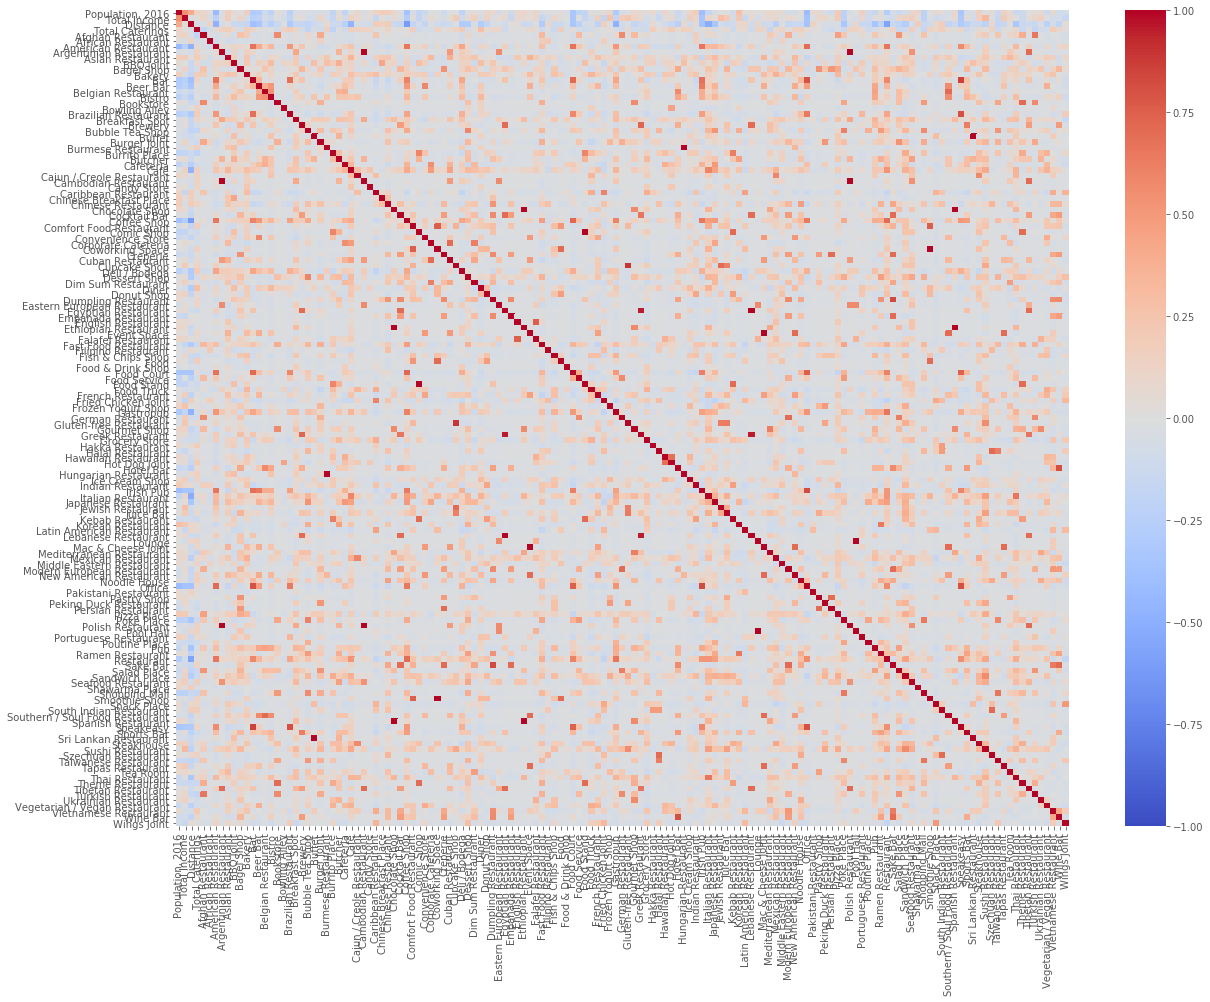

In [290]:
corr = plot_data.corr()

plt.subplots(figsize=(20,15))

#plt.figure(figsize=(15,10))

sns.heatmap(corr,
            cmap='coolwarm',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot_kws={"size":8},
            vmin=-1)
plt.show()

Clearly, through the red spots can we say that there some correlations between some kind of catering businesses, also the blue left and top edges show some signs of negative correlation between income, population levels, distance from Toronto city center and some type of catering businesses. let's explore further these correlation relationships to get further insights.

#### Relationship catering counts with distance, income or population

In [291]:
plot_data=data.iloc[:,5:9]

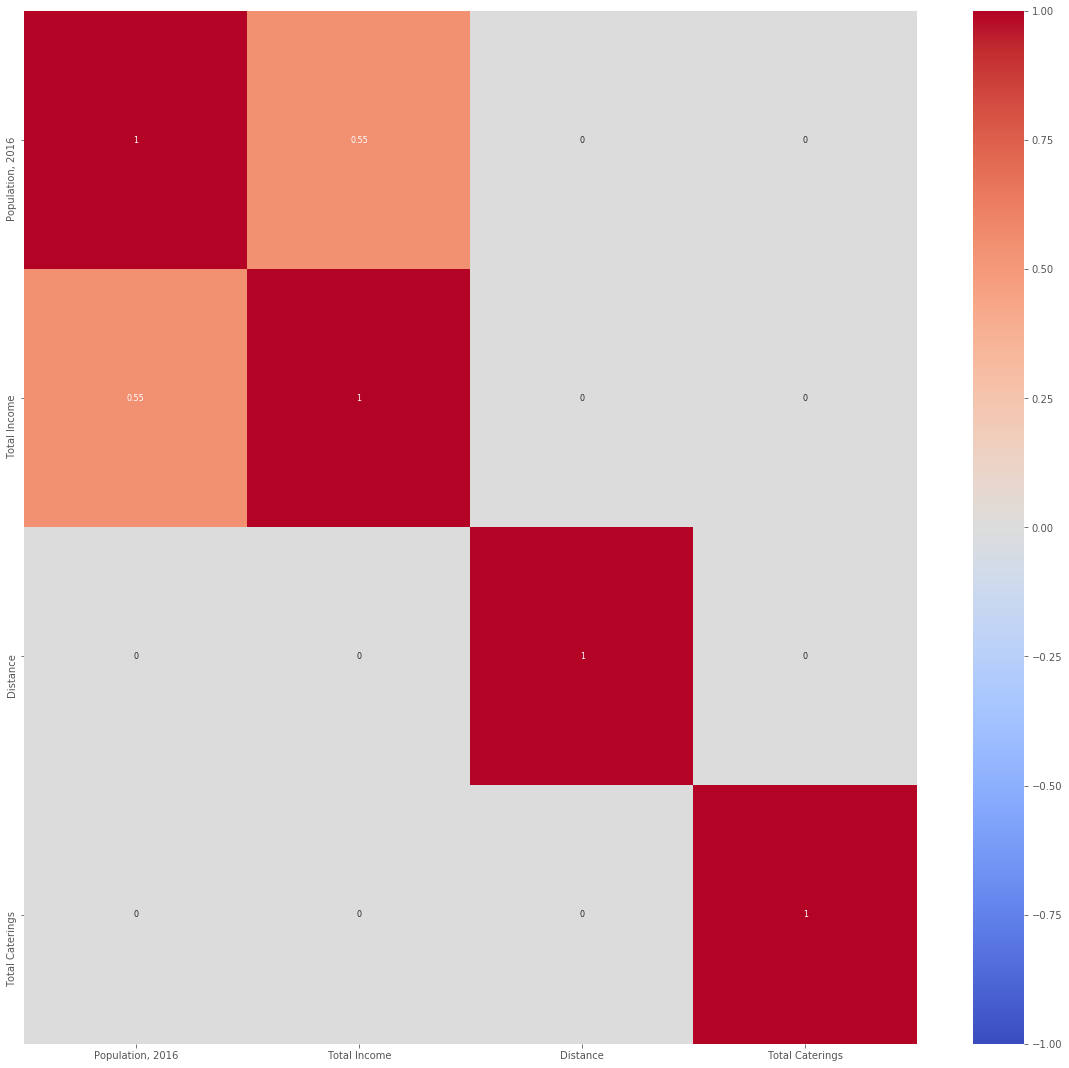

In [292]:
corr = plot_data.corr()
corr =corr.mask((corr > -0.5) & (corr< 0.5), 0)
plt.figure(figsize=(20,19))
sns.heatmap(corr, 
            cmap='coolwarm',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot_kws={"size":8},
            annot=True,
            vmin=-1)
plt.show()

No palpable correlation between the number of catering business and the population and income levels, yet we can see that there is slight positive correlation between population and income levels with a pearson correlation factor of 0.55.

#### Relationship between catering businesses

let's consider only the dataset revolving around catering venues types and their counts per FSA

In [293]:
#keep only detailed catering counts
plot_data=data.iloc[:,9:150]

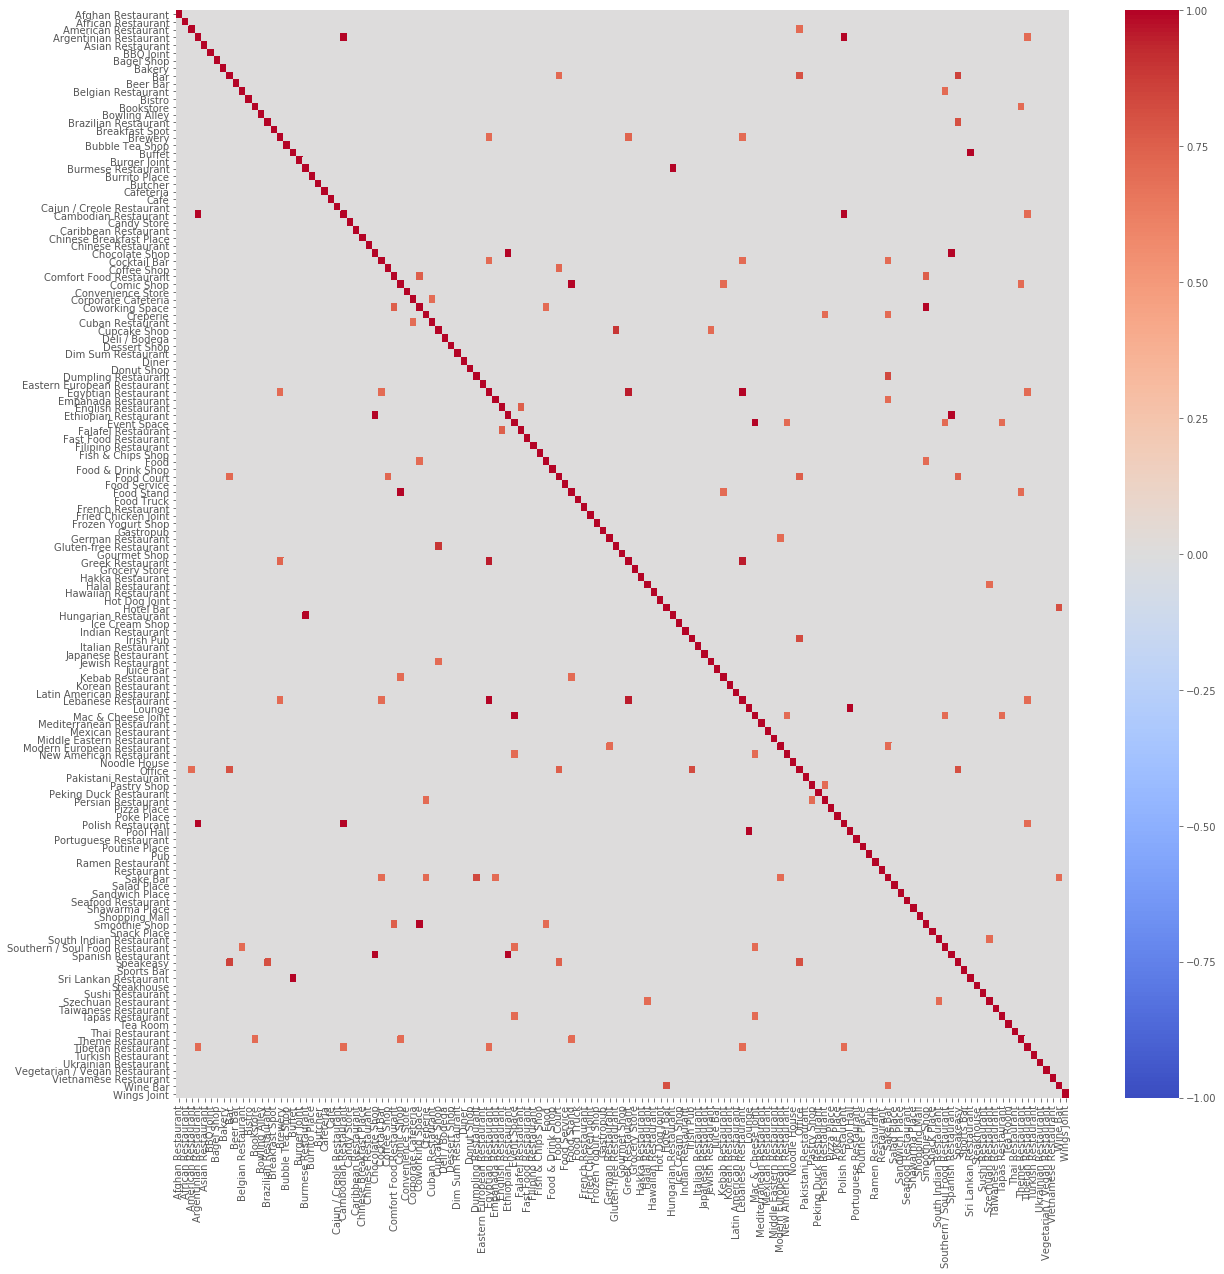

In [294]:
corr = plot_data.corr()
corr =corr.mask((corr > -0.7) & (corr
                               < 0.7), 0)
plt.figure(figsize=(20,20))
sns.heatmap(corr, 
            cmap='coolwarm',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot_kws={"size":8},
            vmin=-1)
plt.show()

mmm, this heatmap is not so talkative, as it looks from the figure that there are several catering types of business with  large relationship, still are these business relevant quantitatively?  Let's follow this intuition and perform some filtering and keep only the catering businesses with relevant number of occurencies across the Toronto FSAs.   
Let's plot the data to see if the intuition makes sense  

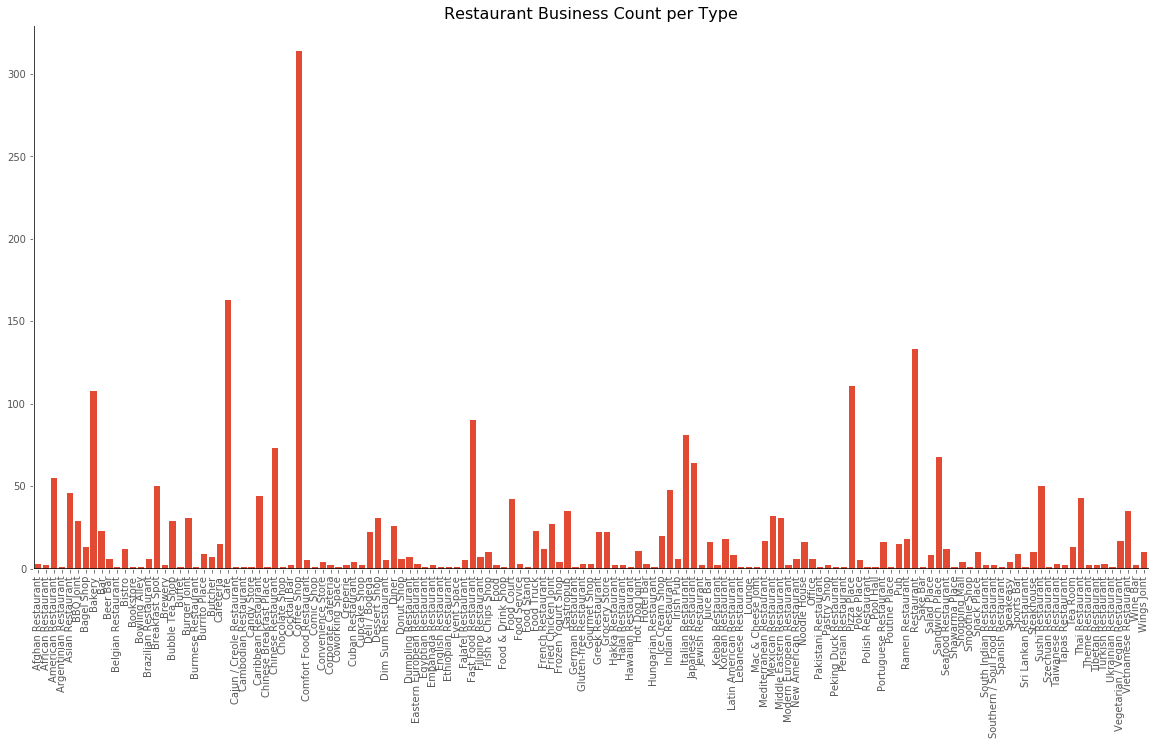

In [295]:
totals=plot_data.sum(axis=0)
ax=totals.plot(kind='bar', width=0.8, grid=False, figsize=(20,10))
# format the income values into Millions
#ax.yaxis.set_major_formatter(formatter)
#Change the legend font size 
#plt.legend( prop={"size":14})
#set the background color to white
ax.set_facecolor('white')
#draw the x axis
plt.axhline(0, color='black')
#draw the y axis
plt.axvline(-0.5, color='black')
#plot the graph title
plt.title('Restaurant Business Count per Type' , fontsize=16)
plt.show()

From the describe() method, we see that the 75th percentile of the caterings businesses have a count of 4 

In [296]:
plot_data.describe().loc["75%"].max()

4.0

Our filtering condition is then set, let's keep only the catering business types with at least 4 counts, as first step we gather into a list all the catering types and computes the respective sum per type

In [297]:
plot_data=data.iloc[:,9:150]
plot_data.columns

Index(['Afghan Restaurant', 'African Restaurant', 'American Restaurant',
       'Argentinian Restaurant', 'Asian Restaurant', 'BBQ Joint', 'Bagel Shop',
       'Bakery', 'Bar', 'Beer Bar',
       ...
       'Tea Room', 'Thai Restaurant', 'Theme Restaurant', 'Tibetan Restaurant',
       'Turkish Restaurant', 'Ukrainian Restaurant',
       'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant', 'Wine Bar',
       'Wings Joint'],
      dtype='object', length=141)

In [298]:
totals=plot_data.sum(axis=0)

We go through our catering data and drop each type that has a sum less than 4 

In [299]:

# scan all columns in our catering dataset
for item in plot_data.columns:
    
    # remove all catering type with a count less than 4
    if (totals[item]) < 4 :   
        print(item)
        plot_data.drop(item,axis=1,inplace=True)
    
    #    plot_data.drop(plot_data.columns[i], axis=1, inplace=True)#removes catering type with given ith index



Afghan Restaurant
African Restaurant
Argentinian Restaurant
Belgian Restaurant
Bookstore
Bowling Alley
Brewery
Buffet
Burmese Restaurant
Cajun / Creole Restaurant
Cambodian Restaurant
Candy Store
Chinese Breakfast Place
Chocolate Shop
Cocktail Bar
Comic Shop
Corporate Cafeteria
Coworking Space
Creperie
Cupcake Shop
Eastern European Restaurant
Egyptian Restaurant
Empanada Restaurant
English Restaurant
Ethiopian Restaurant
Event Space
Food
Food & Drink Shop
Food Service
Food Stand
German Restaurant
Gluten-free Restaurant
Gourmet Shop
Hakka Restaurant
Halal Restaurant
Hawaiian Restaurant
Hotel Bar
Hungarian Restaurant
Jewish Restaurant
Kebab Restaurant
Lebanese Restaurant
Lounge
Mac & Cheese Joint
Modern European Restaurant
Pakistani Restaurant
Pastry Shop
Peking Duck Restaurant
Persian Restaurant
Polish Restaurant
Pool Hall
Poutine Place
Sake Bar
Shawarma Place
Smoothie Shop
South Indian Restaurant
Southern / Soul Food Restaurant
Spanish Restaurant
Sri Lankan Restaurant
Szechuan Restaura

Now that we have a less "noisy" catering dataset, let's investigate the relationship of population, income levels with the catering type

In [300]:
plot_data.insert(0,"Income",data["Total Income"])
plot_data.insert(1,"Population, 2016",data["Population, 2016"])
plot_data.insert(2,"Distance",data["Distance"])

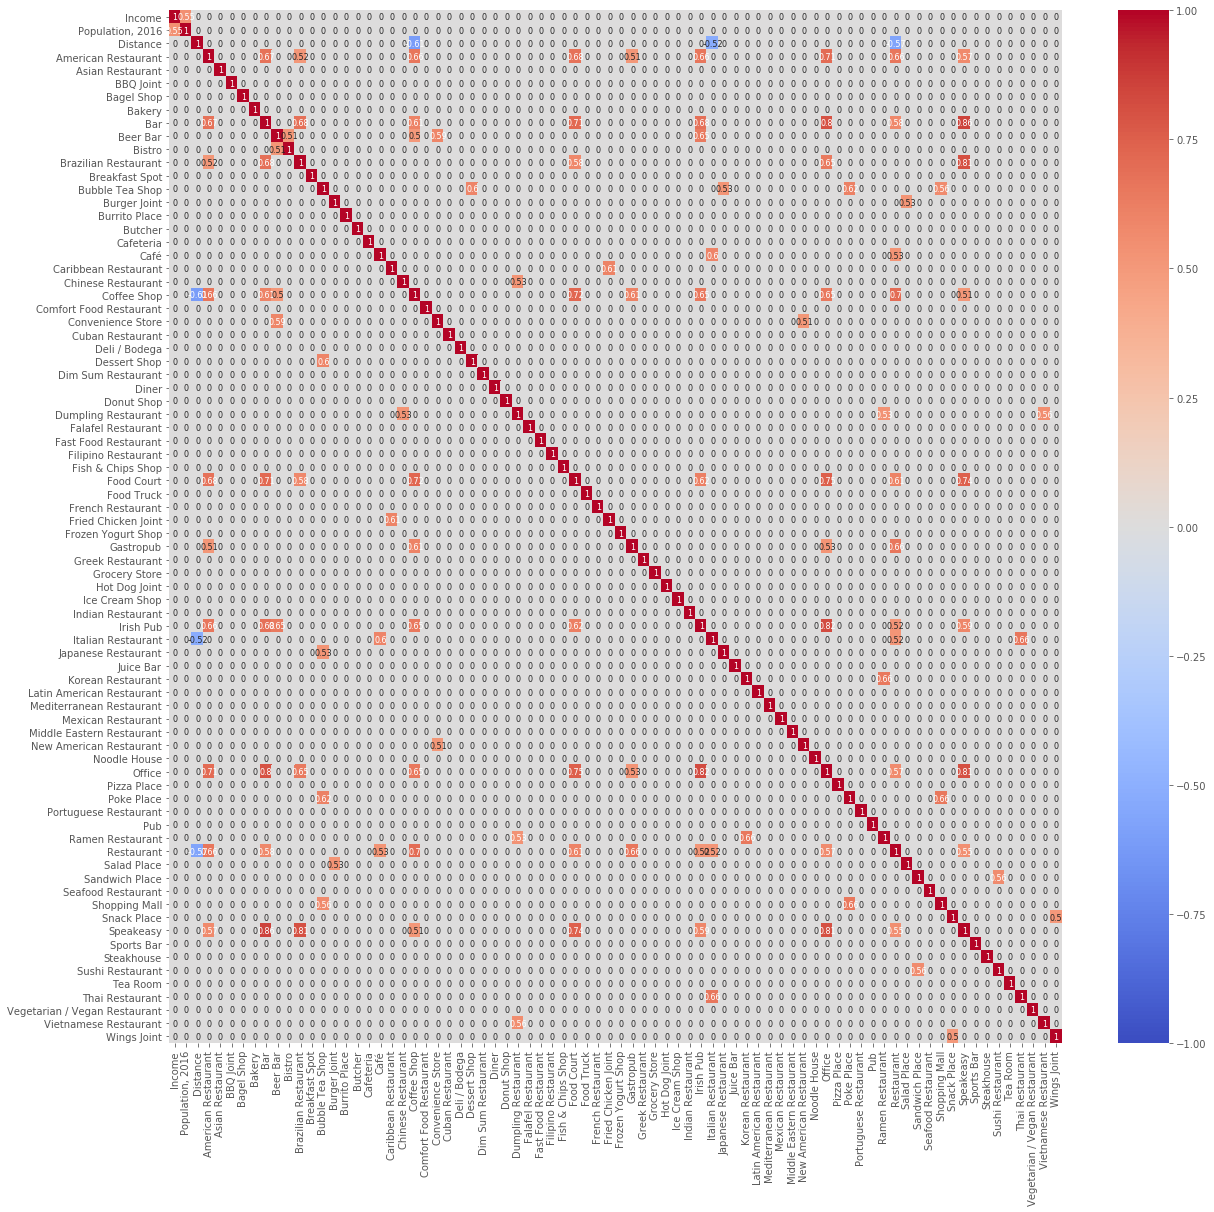

In [301]:
corr = plot_data.corr()
corr =corr.mask((corr > -0.5) & (corr< 0.5), 0)
plt.figure(figsize=(20,19))
sns.heatmap(corr, 
            cmap='coolwarm',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot_kws={"size":8},
            annot=True,
            vmin=-1)
plt.show()

We get the double confirmation that income and population levels have no correlation with a any type of catering businesses, however we see that there is a negative correlation between the distance to the city center and few catering business types, namely coffees shops and general type of restaurants. so the closer we are towards Toronto City Halls, the more important would be the occurencies of coffees and restaurants.

In [302]:
def compute_correlation(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    rmatrix = dfcols.transpose().join(dfcols, how='outer')
    featureList = []
    count = 0
    for row in df.columns:
        for col in df.columns[count:]:
            (r, p) = pearsonr(df[row], df[col])
            if abs(r - 1) > 0.01 and r > 0.6 and p < 0.05:
                featureList.append([row, col, r, p])
                rmatrix[row][col] = r
                rmatrix[col][row] = r
        count += 1
    rmatrix.fillna(value=np.nan, inplace=True)
    df_Features = pd.DataFrame(sorted(featureList, reverse=True,
                               key=lambda x: x[2]),
                               columns=['Restaurant Type 1',
                               'Restaurant Type 2',
                               "Correlation Coefficient 'r'", 'p-value'
                               ])
    return (rmatrix, df_Features)

In [303]:
(rmatrix, df_Features) = compute_correlation(plot_data)
df_Features.shape[0]

34

In [304]:
df_Features.head(60)

Restaurant Type 1     Restaurant Type 2  Correlation Coefficient 'r'  \
0                    Bar             Speakeasy                     0.857367   
1              Irish Pub                Office                     0.823024   
2   Brazilian Restaurant             Speakeasy                     0.808207   
3                 Office             Speakeasy                     0.808207   
4                    Bar                Office                     0.797959   
5             Food Court                Office                     0.750266   
6             Food Court             Speakeasy                     0.744547   
7            Coffee Shop            Food Court                     0.721999   
8                    Bar            Food Court                     0.714163   
9    American Restaurant                Office                     0.706459   
10           Coffee Shop            Restaurant                     0.696733   
11                   Bar  Brazilian Restaurant                     0.681129   
12                   Bar             Irish Pub                     0.681129   
13   American Restaurant            Food Court                     0.675422   
14   American Restaurant                   Bar                     0.673231   
15   American Restaurant            Restaurant                     0.661410   
16             Gastropub            Restaurant                     0.660812   
17    Italian Restaurant       Thai Restaurant                     0.659723   
18   American Restaurant             Irish Pub                     0.658713   
19   American Restaurant           Coffee Shop                     0.657045   
20     Korean Restaurant      Ramen Restaurant                     0.656132   
21            Poke Place         Shopping Mall                     0.656073   
22           Coffee Shop             Irish Pub                     0.649657   
23           Coffee Shop                Office                     0.649657   
24              Beer Bar             Irish Pub                     0.646048   
25  Brazilian Restaurant                Office                     0.646048   
26            Food Court             Irish Pub                     0.622040   
27       Bubble Tea Shop            Poke Place                     0.616821   
28            Food Court            Restaurant                     0.609276   
29                   Bar           Coffee Shop                     0.607710   
30  Caribbean Restaurant   Fried Chicken Joint                     0.607052   
31           Coffee Shop             Gastropub                     0.606656   
32                  Café    Italian Restaurant                     0.601408   
33       Bubble Tea Shop          Dessert Shop                     0.600360   

         p-value  
0   6.783177e-31  
1   1.482488e-26  
2   5.794952e-25  
3   5.794952e-25  
4   6.101113e-24  
5   7.407324e-20  
6   1.984420e-19  
7   7.592856e-18  
8   2.480615e-17  
9   7.648626e-17  
10  3.012309e-16  
11  2.432895e-15  
12  2.432895e-15  
13  5.059713e-15  
14  6.672795e-15  
15  2.854766e-14  
16  3.067260e-14  
17  3.494459e-14  
18  3.941544e-14  
19  4.803927e-14  
20  5.350387e-14  
21  5.387595e-14  
22  1.136857e-13  
23  1.136857e-13  
24  1.716993e-13  
25  1.716993e-13  
26  2.331087e-12  
27  3.991578e-12  
28  8.536802e-12  
29  9.971349e-12  
30  1.064067e-11  
31  1.106449e-11  
32  1.846833e-11  
33  2.043417e-11

In [305]:
for col in rmatrix:
    if rmatrix[col].sum() == 0:
        rmatrix.drop(col, axis=1, inplace=True)
        rmatrix.drop(col, axis=0, inplace=True)
rmatrix

American Restaurant       Bar  Beer Bar  \
American Restaurant                   NaN  0.673231       NaN   
Bar                              0.673231       NaN       NaN   
Beer Bar                              NaN       NaN       NaN   
Brazilian Restaurant                  NaN  0.681129       NaN   
Bubble Tea Shop                       NaN       NaN       NaN   
Café                                  NaN       NaN       NaN   
Caribbean Restaurant                  NaN       NaN       NaN   
Coffee Shop                      0.657045  0.607710       NaN   
Dessert Shop                          NaN       NaN       NaN   
Food Court                       0.675422  0.714163       NaN   
Fried Chicken Joint                   NaN       NaN       NaN   
Gastropub                             NaN       NaN       NaN   
Irish Pub                        0.658713  0.681129  0.646048   
Italian Restaurant                    NaN       NaN       NaN   
Korean Restaurant                     NaN       NaN       NaN   
Office                           0.706459  0.797959       NaN   
Poke Place                            NaN       NaN       NaN   
Ramen Restaurant                      NaN       NaN       NaN   
Restaurant                       0.661410       NaN       NaN   
Shopping Mall                         NaN       NaN       NaN   
Speakeasy                             NaN  0.857367       NaN   
Thai Restaurant                       NaN       NaN       NaN   

                      Brazilian Restaurant  Bubble Tea Shop      Café  \
American Restaurant                    NaN              NaN       NaN   
Bar                               0.681129              NaN       NaN   
Beer Bar                               NaN              NaN       NaN   
Brazilian Restaurant                   NaN              NaN       NaN   
Bubble Tea Shop                        NaN              NaN       NaN   
Café                                   NaN              NaN       NaN   
Caribbean Restaurant                   NaN              NaN       NaN   
Coffee Shop                            NaN              NaN       NaN   
Dessert Shop                           NaN         0.600360       NaN   
Food Court                             NaN              NaN       NaN   
Fried Chicken Joint                    NaN              NaN       NaN   
Gastropub                              NaN              NaN       NaN   
Irish Pub                              NaN              NaN       NaN   
Italian Restaurant                     NaN              NaN  0.601408   
Korean Restaurant                      NaN              NaN       NaN   
Office                            0.646048              NaN       NaN   
Poke Place                             NaN         0.616821       NaN   
Ramen Restaurant                       NaN              NaN       NaN   
Restaurant                             NaN              NaN       NaN   
Shopping Mall                          NaN              NaN       NaN   
Speakeasy                         0.808207              NaN       NaN   
Thai Restaurant                        NaN              NaN       NaN   

                      Caribbean Restaurant  Coffee Shop  Dessert Shop  \
American Restaurant                    NaN     0.657045           NaN   
Bar                                    NaN     0.607710           NaN   
Beer Bar                               NaN          NaN           NaN   
Brazilian Restaurant                   NaN          NaN           NaN   
Bubble Tea Shop                        NaN          NaN       0.60036   
Café                                   NaN          NaN           NaN   
Caribbean Restaurant                   NaN          NaN           NaN   
Coffee Shop                            NaN          NaN           NaN   
Dessert Shop                           NaN          NaN           NaN   
Food Court                             NaN     0.721999           NaN   
Fried Chicken Joint               0.607052 

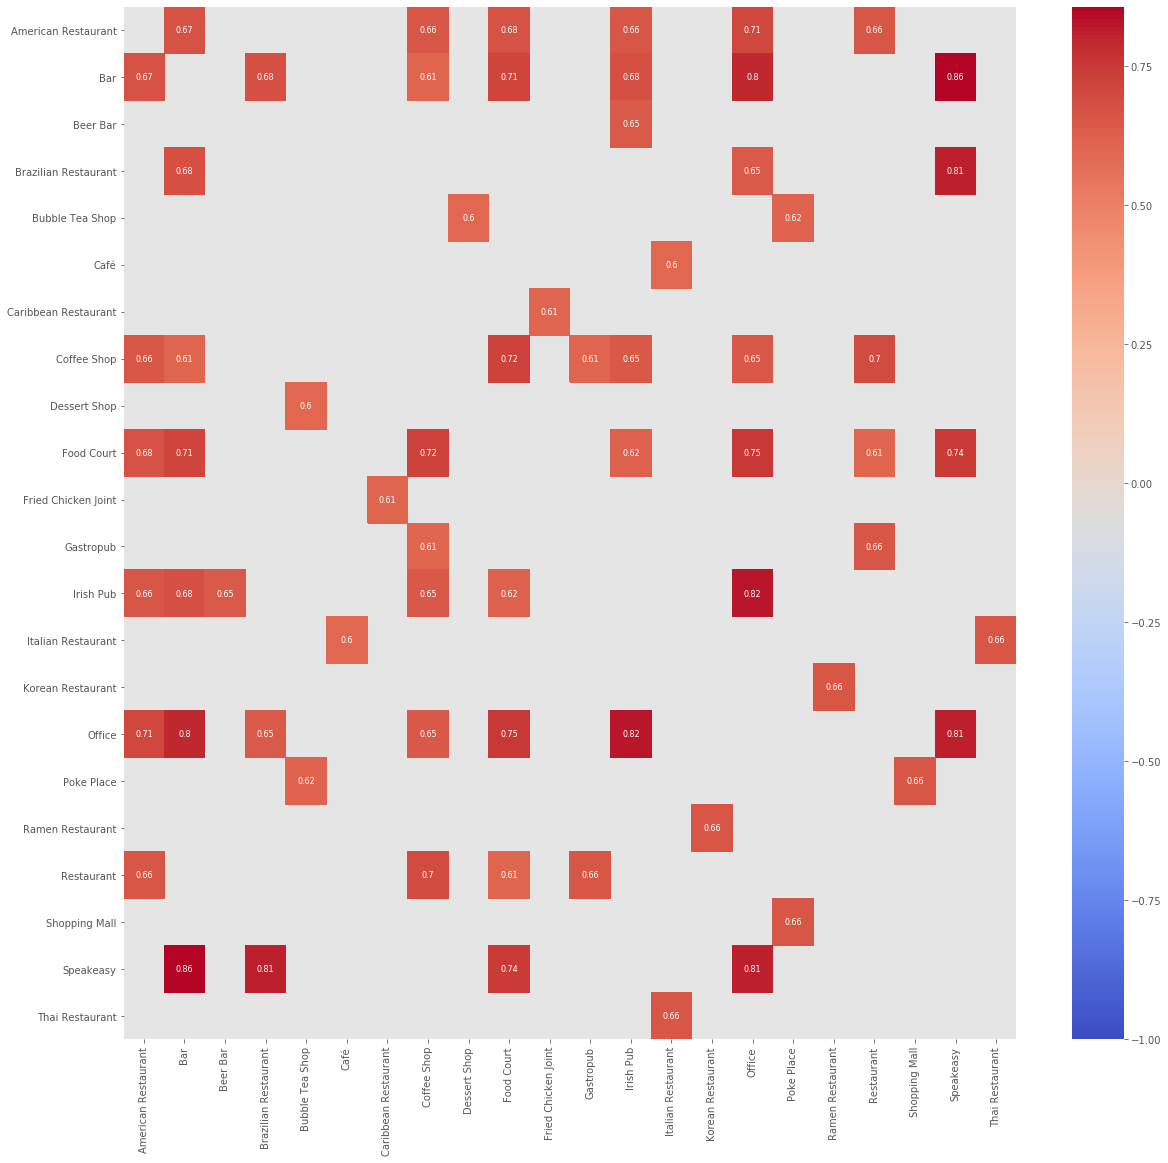

In [306]:

plt.figure(figsize=(20,19))
sns.heatmap(rmatrix, 
            cmap='coolwarm',
            xticklabels=rmatrix.columns.values,
            yticklabels=rmatrix.columns.values,
            annot_kws={"size":8},
            annot=True,
            vmin=-1)
plt.show()

### Neighborhoods Clusters Analysis

let us now analyze the Toronto neighbourhoods and assess if there are similarities, differencies between groups of neighbourhoods based on the catering features set.

We will relay on k-means to accomplish this task, as k-means clustering is a method of vector quantization, originally created from signal processing, its obective is to partition n entities into k clusters in which each entity is related to the cluster with closest mean or basically the centroid of the cluster.  

Our first step would be then to determine the optimal k parameter, that would provide us with the most accurate results; we can rely on the elbow method in this regard, which is a heuristic method of determining a consistency within a cluster analysis in order to find the appropriate k parameter, namely the number of clusters we can get out of a given dataset. 

In [307]:
data.head()

Postcode      Borough                             Neighbourhood   Latitude  \
0      M1B  Scarborough                           Malvern / Rouge  43.806686   
1      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek  43.784535   
2      M1E  Scarborough       Guildwood / Morningside / West Hill  43.763573   
3      M1G  Scarborough                                    Woburn  43.770992   
4      M1H  Scarborough                                 Cedarbrae  43.773136   

   Longitude  Population, 2016  Total Income   Distance  Total Caterings  \
0 -79.194353           66108.0  1.577233e+09  22.461327              9.0   
1 -79.160497           35626.0  1.483624e+09  22.561648             23.0   
2 -79.188711           46943.0  1.320927e+09  19.958508             16.0   
3 -79.216917           29690.0  6.372060e+08  18.459028              5.0   
4 -79.239476           24383.0  6.152230e+08  17.901511             49.0   

   Afghan Restaurant  ...  $45,000 to $49,999  $50,000 to $54,999  \
0                0.0  ...                2280                1900   
1                0.0  ...                1320                1200   
2                0.0  ...                1550                1280   
3                0.0  ...                 860                 640   
4                0.0  ...                 800                 640   

   $55,000 to $59,999  $60,000 to $69,999  $70,000 to $79,999  \
0                1560                2290                1550   
1                1060                1850                1580   
2                1140                1730                1350   
3                 540                 800                 610   
4                 560                 820                 640   

   $80,000 to $89,999  $90,000 to $99,999  $100,000 to $149,999  \
0                 920                 720                  1070   
1                1210                1200                  2250   
2                 930                 840                  1310   
3                 400                 280                   440   
4                 420                 330                   480   

   $150,000 to $249,999  $250,000 and over  
0                   200                 40  
1                   770                270  
2                   390                140  
3                    80                 20  
4                   130                 30  

[5 rows x 170 columns]

#### The Elbow method

In [308]:

cluster_data=data.iloc[:,5:]

#let's add the income ranges as a test


cluster_data.head()
cluster_data.isna()
#Scaling features 
#mms = MinMaxScaler()
#mms.fit(cluster_data)
#cluster_data = mms.transform(cluster_data)

Population, 2016  Total Income  Distance  Total Caterings  \
0               False         False     False            False   
1               False         False     False            False   
2               False         False     False            False   
3               False         False     False            False   
4               False         False     False            False   
..                ...           ...       ...              ...   
98              False         False     False            False   
99              False         False     False            False   
100             False         False     False            False   
101             False         False     False            False   
102             False         False     False            False   

     Afghan Restaurant  African Restaurant  American Restaurant  \
0                False               False                False   
1                False               False                False   
2                False               False                False   
3                False               False                False   
4                False               False                False   
..                 ...                 ...                  ...   
98               False               False                False   
99               False               False                False   
100              False               False                False   
101              False               False                False   
102              False               False                False   

     Argentinian Restaurant  Asian Restaurant  BBQ Joint  ...  \
0                     False             False      False  ...   
1                     False             False      False  ...   
2                     False             False      False  ...   
3                     False             False      False  ...   
4                     False             False      False  ...   
..                      ...               ...        ...  ...   
98                    False             False      False  ...   
99                    False             False      False  ...   
100                   False             False      False  ...   
101                   False             False      False  ...   
102                   False             False      False  ...   

     $45,000 to $49,999  $50,000 to $54,999  $55,000 to $59,999  \
0                 False               False               False   
1                 False               False               False   
2                 False               False               False   
3                 False               False               False   
4                 False               False               False   
..                  ...                 ...                 ...   
98                False               False               False   
99                False               False               False   
100               False               False               False   
101               False               False               False   
102               False               False               False   

     $60,000 to $69,999  $70,000 to $79,999  $80,000 to $89,999  \
0                 False               False               False   
1                 False               False               False   
2                 False               False               False   
3                 False               False               False   
4                 False               False               False   
..                  ...                 ...                 ...   
98                False               False               False   
99                False               False               False   
100               False               False               False   
101               False               False               False   
102               False               False               False   

     $90,000 to 

In [309]:
#Elbow Method
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(cluster_data)
    Sum_of_squared_distances.append(kmeans.inertia_)
    
    

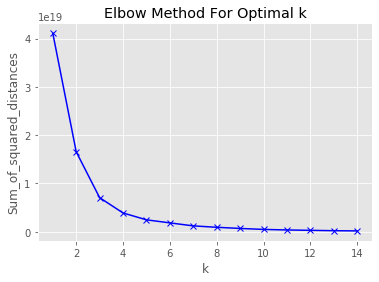

In [310]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It is not straighforward to say from the elbow method that K is at 3 or 4, lets complement this method by another approach 

#### The Silhouette Method

The Silhouette method is another mean to determine the optimal K parameter or the number of clusters. The silhouette coefficient of a dataset measures how well close a given data is towards its own cluster and how far it is from other clusters. A silhouette coefficient close to 1 represent data points that are labeled under an appropriate cluster, wheread a coefficient close to −1 shows data points that are wrongly labeled implies under clusters.  

In [311]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 6

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(cluster_data)
  labels = kmeans.labels_
  sil.append(silhouette_score(cluster_data, labels, metric = 'euclidean'))

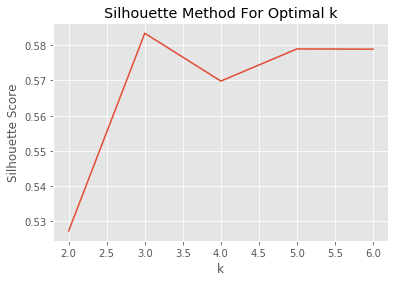

In [312]:
plt.plot(range(2, kmax+1), sil)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

We see from the figure above that with K=3we have a better silhouette score than with K=4. Please note that the Elbow Method and the Silhouette Method are not really substitutes to each other but more means that can be used altogether to find K especially when finding the elbow is not straighforward.

#### Cluster Analysis

In [313]:
# set number of clusters
kclusters = 3


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0,
       1, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 1, 1,
       2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2,
       0, 2, 0, 0, 2, 1, 0, 0, 2, 2, 2, 2, 0, 0, 0])

In [314]:
data.shape

(103, 170)

In [315]:

cluster_data_analysis=data
cluster_data_analysis.insert(3,'Cluster',kmeans.labels_[:])

In [316]:
cluster_data_analysis.head()

Postcode      Borough                             Neighbourhood  Cluster  \
0      M1B  Scarborough                           Malvern / Rouge        0   
1      M1C  Scarborough  Rouge Hill / Port Union / Highland Creek        0   
2      M1E  Scarborough       Guildwood / Morningside / West Hill        0   
3      M1G  Scarborough                                    Woburn        2   
4      M1H  Scarborough                                 Cedarbrae        2   

    Latitude  Longitude  Population, 2016  Total Income   Distance  \
0  43.806686 -79.194353           66108.0  1.577233e+09  22.461327   
1  43.784535 -79.160497           35626.0  1.483624e+09  22.561648   
2  43.763573 -79.188711           46943.0  1.320927e+09  19.958508   
3  43.770992 -79.216917           29690.0  6.372060e+08  18.459028   
4  43.773136 -79.239476           24383.0  6.152230e+08  17.901511   

   Total Caterings  ...  $45,000 to $49,999  $50,000 to $54,999  \
0              9.0  ...                2280                1900   
1             23.0  ...                1320                1200   
2             16.0  ...                1550                1280   
3              5.0  ...                 860                 640   
4             49.0  ...                 800                 640   

   $55,000 to $59,999  $60,000 to $69,999  $70,000 to $79,999  \
0                1560                2290                1550   
1                1060                1850                1580   
2                1140                1730                1350   
3                 540                 800                 610   
4                 560                 820                 640   

   $80,000 to $89,999  $90,000 to $99,999  $100,000 to $149,999  \
0                 920                 720                  1070   
1                1210                1200                  2250   
2                 930                 840                  1310   
3                 400                 280                   440   
4                 420                 330                   480   

   $150,000 to $249,999  $250,000 and over  
0                   200                 40  
1                   770                270  
2                   390                140  
3                    80                 20  
4                   130                 30  

[5 rows x 171 columns]

#### Cluster Visualization and Analysis

let's visualize these clusters in the map

In [317]:
legend = np.linspace(toronto_combined_data['Population, 2016'].min(),
                              toronto_combined_data['Population, 2016'].max(),
                              6,dtype=int)
legend = legend.tolist()
#print(legend)

map_toronto_clusters = folium.Map(location=[43.653963, -79.387207], zoom_start=10)
ontario_geo = "toronto_FSA.geojson"
map_toronto_clusters.choropleth(geo_data=ontario_geo,
    data = cluster_data_analysis,
    columns=['Postcode','Population, 2016'],
    key_on='feature.properties.CFSAUID',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,              
    legend_name='Population by FSA',
    threshold_scale=[0, 15000, 30000, 45000, 60000, 76000])   


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_data_analysis['Latitude'], cluster_data_analysis['Longitude'], cluster_data_analysis['Neighbourhood'], cluster_data_analysis['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_toronto_clusters)




map_toronto_clusters



In [325]:
legend = np.linspace(toronto_combined_data['Total Income'].min(),
                              toronto_combined_data['Total Income'].max(),
                              6,dtype=float)
legend = legend.tolist()
#print(legend)

map_toronto_clusters = folium.Map(location=[43.653963, -79.387207], zoom_start=10)
ontario_geo = "toronto_FSA.geojson"
map_toronto_clusters.choropleth(geo_data=ontario_geo,
    data = cluster_data_analysis,
    columns=['Postcode','Total Income'],
    key_on='feature.properties.CFSAUID',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,              
    legend_name='Annual Income (USD) by FSA',
    threshold_scale=[0.0, 100000000.0, 500000000.0, 1000000000.0, 2000000000.0, 3200000000.0])   


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, pc, poi, cluster in zip(cluster_data_analysis['Latitude'], cluster_data_analysis['Longitude'], cluster_data_analysis['Postcode'],cluster_data_analysis['Neighbourhood'], cluster_data_analysis['Cluster']):
    label = folium.Popup(str(pc) + str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_toronto_clusters)




map_toronto_clusters



Let's merge the data used for the clusters analysis with the Toronto catering data to output the 10 most frequent catering types per cluster 

In [319]:
top_catering=pd.DataFrame(columns=['Cluster','Catering type','Totals','Habitants per business'])
total_population=[]
total_income=[]
total_catering=[]
zero_catering=[]
total_neighbourhood=[]
for i in range(0,kclusters):
    total_population.append(round(cluster_data_analysis[cluster_data_analysis['Cluster']==i]['Population, 2016'].sum(axis=0),0))
    total_income.append(round(cluster_data_analysis[cluster_data_analysis['Cluster']==i]['Total Income'].sum(axis=0),0))
    total_catering.append(round(cluster_data_analysis[cluster_data_analysis['Cluster']==i]['Total Caterings'].sum(axis=0),0))
    zero_catering.append(len(cluster_data_analysis[(cluster_data_analysis['Cluster']==i) & (cluster_data_analysis['Total Caterings']==0.0)].index))
    total_neighbourhood.append(len(cluster_data_analysis[cluster_data_analysis['Cluster']==i]))
    
    print("Cluster :",i+1)
    print()
    print("Nb of Neighborhoods :", total_neighbourhood[i])
    print("Total Income in BUSD:",round(total_income[i]/1000000000,2))
    print("Total population :", total_population[i])
    print("Total Food Businesses :",total_catering[i])
    print("Businesses per Neighborhood :",round(total_catering[i]/total_neighbourhood[i],2))
    print("Nb of Habitants per food business :",round(total_population[i]/total_catering[i],0))
    print("Income in MUSD per food business :",round(total_income[i]/total_catering[i]/1000000,0))
    print("Average income per habitant :",round(total_income[i]/total_population[i],0))
    print("Percentage of Neighboorhoods with no food business :{}%".format(round(zero_catering[i]/total_neighbourhood[i]*100,2)))
    print()
    print("Top 10 food businesses :")
    
    #select 10:151 to get only the catering types dataset and perform the sorting operation
    top_catering_percluster=cluster_data_analysis[cluster_data_analysis['Cluster']==i].iloc[:,10:151].sum(axis=0).sort_values(ascending=False).head(20).to_frame()
    top_catering_percluster.reset_index(level=0, inplace=True)
    top_catering_percluster.rename(columns={0:'Totals','index':'Catering type'},inplace=True)
    top_catering_percluster.insert(0, 'Cluster', i)
    top_catering_percluster.insert(3, 'Habitants per business', round(total_population[i]/top_catering_percluster['Totals'],0))
    top_catering=pd.concat([top_catering,top_catering_percluster ], ignore_index=True)
    print(top_catering_percluster.head(10).to_string(index=False))
    print()

print("Toronto Global:")
print()
print("Nb of Neighborhoods :", sum(total_neighbourhood))
print("Total Income in BUSD:",round(sum(total_income)/1000000000,2))
print("Total population :", sum(total_population))
print("Total Food Businesses :",sum(total_catering))
print("Businesses per Neighborhood :",round(sum(total_catering)/sum(total_neighbourhood),2))
print("Nb of Habitants per food business :",round(sum(total_population)/sum(total_catering),0))
print("Income in MUSD per food business :",round(sum(total_income)/sum(total_catering)/1000000,0))
print("Average income per habitant :",round(sum(total_income)/sum(total_population),0))
print("Percentage of Neighboorhoods with no food business :{}%".format(round(sum(zero_catering)/sum(total_neighbourhood)*100,2)))
print()

Cluster : 1

Nb of Neighborhoods : 53
Total Income in BUSD: 68.74
Total population : 1774689.0
Total Food Businesses : 1324.0
Businesses per Neighborhood : 24.98
Nb of Habitants per food business : 1340.0
Income in MUSD per food business : 52.0
Average income per habitant : 38732.0
Percentage of Neighboorhoods with no food business :9.43%

Top 10 food businesses :
 Cluster         Catering type  Totals  Habitants per business
       0           Coffee Shop   123.0                 14428.0
       0                  Café    95.0                 18681.0
       0                Bakery    64.0                 27730.0
       0           Pizza Place    64.0                 27730.0
       0            Restaurant    61.0                 29093.0
       0  Fast Food Restaurant    45.0                 39438.0
       0    Italian Restaurant    44.0                 40334.0
       0    Chinese Restaurant    39.0                 45505.0
       0        Sandwich Place    35.0                 50705.0
   

Cluster 1, represents the largest cluster of neighborhoods not only in terms of number of neighborhoods but also when it comes to population (85% more than the two other clusters combined), income and number of food businesses. Geographically spread over the east and west and the center, on the FSAs for which the global income is over 1B USD as depicted in the map, the first business rank is won by far by Coffee shops and Cafes, which comes as no surprise after our correlation analyis with the distance from the city center (Cluster 2 has strong part close to the city center); then we have at fairly the same importance Pizza Restaurants, restaurants and bakery. Obviously going for a Coffee place within this geograpical cluster would be a quick win but the bakery business would be very interesting as the number of habitants per bakery is the highest within the most succesful food businesses

Cluster 2, the smallest cluster in terms of geographical area and population, but not the least in terms of income, as its FSA have the highest annual income levels in Toronto, the 2016 annual average income per habitant is overing aroung 77K USD more than the combined averages of the two other clusters. Another interesting aspect of this cluster is the number of served habitants per food business of 2218, approximately the double of the Toronto average, reflecting a far below average of food industry coverage and translating into a strong investment factor in this area.  The top ranked businesses are again Coffee shops/Cafés, still they are not really leaving behind the other business as we see in the other clusters, we see a flatter distribution of business types, with asian cuisine restaurants (Japanese, sushi, Indian) and Italian restaurants.  The high income per habitant in this cluster could exlain that we dont a relative strong presence of fast foods.

Cluster 3, is the second largest cluster of neighborhoods in terms of number of neighborhoods and population,  the striking aspect coming out of this cluster is that its revenues are the lowest, and the annual average revenue per habitant is around 30K USD below the Toronto average by more than 20%; the food sector coverage is around 716 habitants per business, in other words, a staggering -38% compared to the Toronto average. By no surprise the thriving business within this sector is also the coffee shops, yet Cluster 3 get the first rank when it comes to the coffee shops figures; which is aligned with our correlation analysis findings stating that coffee shops counts increases when distance from the city center decreases with Cluster 3 having a strong presence in the city center. The distribution of food business category types is rather aggressive here, as Restaurants, the second top performer is almost three times less frequent, it comes as no surprise to see Restaurant type in this position as well from our previous correlation analysis.  Fast foods and food courts are also very strong here, this could be explained by the relatively low average income, and their coverage make them quite interesting investments assets, while the coffee shops category, despite being a top performer, is not so appealling with its very low habitants/business ratio, especially when we have witnessed tremendeously higher figures for this category within the other 2 clusters.   

#### Further insights

let's assess the income distribution of each cluster, for that we would need to preselect the income ranges from the global Toronto dataset, for that we will check the indexes of the relevant columns:

In [320]:
for i,col in zip(range(0,len(cluster_data_analysis.columns)),cluster_data_analysis.columns):
    print(i,col)

0 Postcode
1 Borough
2 Neighbourhood
3 Cluster
4 Latitude
5 Longitude
6 Population, 2016
7 Total Income
8 Distance
9 Total Caterings
10 Afghan Restaurant
11 African Restaurant
12 American Restaurant
13 Argentinian Restaurant
14 Asian Restaurant
15 BBQ Joint
16 Bagel Shop
17 Bakery
18 Bar
19 Beer Bar
20 Belgian Restaurant
21 Bistro
22 Bookstore
23 Bowling Alley
24 Brazilian Restaurant
25 Breakfast Spot
26 Brewery
27 Bubble Tea Shop
28 Buffet
29 Burger Joint
30 Burmese Restaurant
31 Burrito Place
32 Butcher
33 Cafeteria
34 Café
35 Cajun / Creole Restaurant
36 Cambodian Restaurant
37 Candy Store
38 Caribbean Restaurant
39 Chinese Breakfast Place
40 Chinese Restaurant
41 Chocolate Shop
42 Cocktail Bar
43 Coffee Shop
44 Comfort Food Restaurant
45 Comic Shop
46 Convenience Store
47 Corporate Cafeteria
48 Coworking Space
49 Creperie
50 Cuban Restaurant
51 Cupcake Shop
52 Deli / Bodega
53 Dessert Shop
54 Dim Sum Restaurant
55 Diner
56 Donut Shop
57 Dumpling Restaurant
58 Eastern European Resta

we will then select the cluster data with the income ranges from column 152 till the last one 

In [321]:
# select only the icome distribution data from the whole dataset
list_cols=[cluster_data_analysis.columns[3]] + list(cluster_data_analysis.columns[152:])
income_range_clusters=cluster_data_analysis[list_cols]
income_range_clusters.head()

Cluster  Under $5,000  $5,000 to $9,999  $10,000 to $14,999  \
0        0          8140              4340                5660   
1        0          3340              1780                2250   
2        0          4810              2970                3880   
3        2          4300              2120                2730   
4        2          3500              1510                2040   

   $15,000 to $19,999  $20,000 to $24,999  $25,000 to $29,999  \
0                5470                3790                3140   
1                2120                1630                1310   
2                3610                2680                2100   
3                2630                1760                1390   
4                1870                1490                1210   

   $30,000 to $34,999  $35,000 to $39,999  $40,000 to $44,999  \
0                3050                2740                2560   
1                1270                1300                1380   
2                1930                1860                1720   
3                1210                1070                 940   
4                1090                 980                 910   

   $45,000 to $49,999  $50,000 to $54,999  $55,000 to $59,999  \
0                2280                1900                1560   
1                1320                1200                1060   
2                1550                1280                1140   
3                 860                 640                 540   
4                 800                 640                 560   

   $60,000 to $69,999  $70,000 to $79,999  $80,000 to $89,999  \
0                2290                1550                 920   
1                1850                1580                1210   
2                1730                1350                 930   
3                 800                 610                 400   
4                 820                 640                 420   

   $90,000 to $99,999  $100,000 to $149,999  $150,000 to $249,999  \
0                 720                  1070                   200   
1                1200                  2250                   770   
2                 840                  1310                   390   
3                 280                   440                    80   
4                 330                   480                   130   

   $250,000 and over  
0                 40  
1                270  
2                140  
3                 20  
4                 30

Let's plot that 

Text(0.5, 0.98, 'Income Distribution Per Cluster')

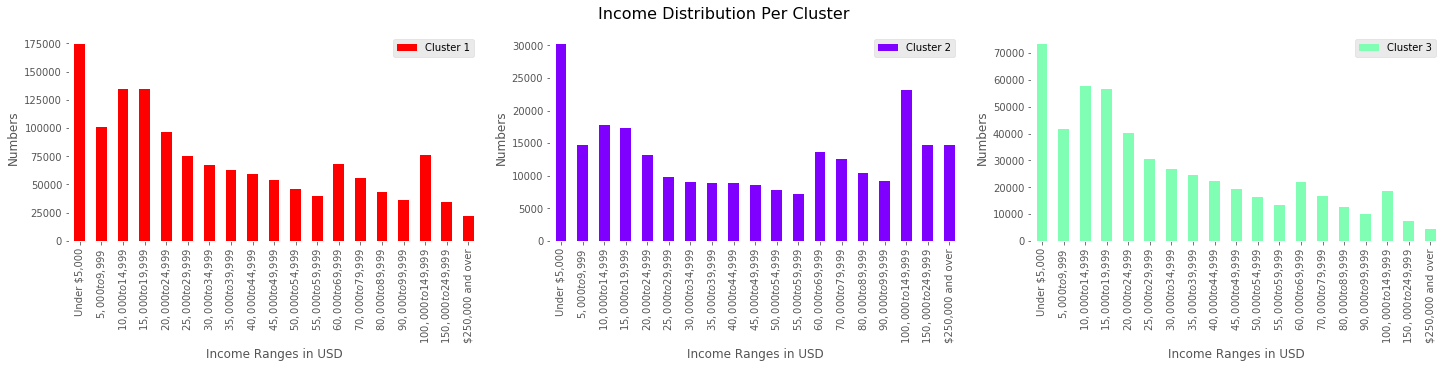

In [322]:
income_clusters=pd.DataFrame()
widths = [1, 1, 1]
heights = [1]
gs_kw = dict(width_ratios=widths, height_ratios=heights)
fig, axarr = plt.subplots(1, kclusters, figsize=(20,5),constrained_layout=True,gridspec_kw=gs_kw)
for i in range(0,kclusters):
    income_per_cluster=(income_range_clusters[income_range_clusters['Cluster']==i].iloc[:,1:].sum(axis=0).to_frame()).rename(columns={0:("Cluster "+str(i+1))})
    income_per_cluster.plot.bar(ax=axarr[i],color=rainbow[int(i-1)])
    income_clusters=pd.concat([income_clusters,income_per_cluster],axis=1,sort=False)

    axarr[i].set_facecolor('white')
    axarr[i].set_ylabel('Numbers')
    axarr[i].set_xlabel('Income Ranges in USD')

fig.suptitle('Income Distribution Per Cluster',fontsize=16)



Text(0.5, 1.0, 'Combined Clusters - Income Distribution')

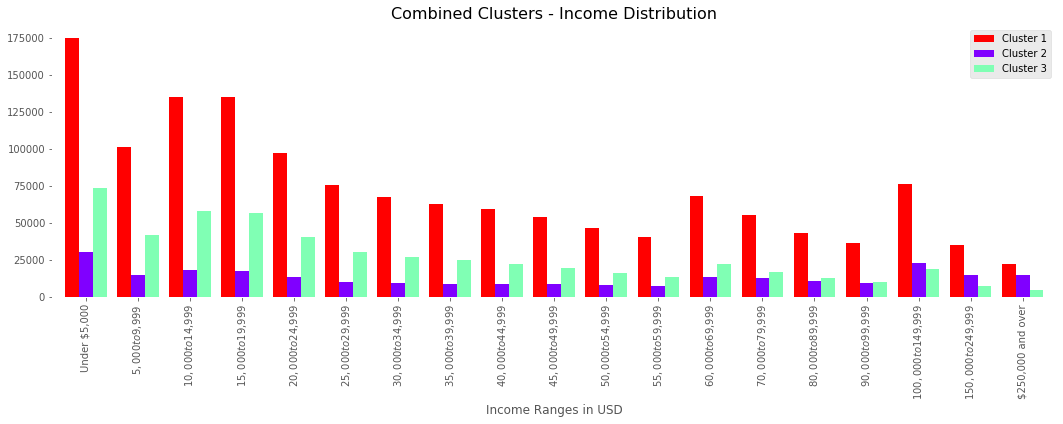

In [323]:
ax=income_clusters.plot(kind='bar', width=0.8, color=['#ff0000','#8000ff', '#80ffb4'], grid=False, figsize=(18,5))
ax.set_facecolor('white')
ax.set_xlabel("Income Ranges in USD")
plt.title('Combined Clusters - Income Distribution' , fontsize=16)

The cluster 1 income distribution depicts that a majority of the inhabitants have their annual income ranging from below 5,000 to 29,999 USD, We can see that there is also a part of the incomes related to a strong middle class (78373 CAD in 2015,83020 CAD in 2017, source from wikipedia), the high income population is also well represented and abide to the ratio of 10% as stated by Statistics Canada (https://www12.statcan.gc.ca/nhs-enm/2011/as-sa/99-014-x/99-014-x2011003_2-eng.cfm)    

Cluster 2, as seen in the cluster analysis had the highest average annual income per habitant, this comes with no surprise as we see from the income distribution that both the middle class and high income fractions are quite significant. Based on this and on previous analysis, more important investments could be undertaken in this cluster to target a high end food market.

The income distribution of Cluster 3 on the other hand shows that the majority of the population within this cluster is ranked as low income class ranging from under 5K to 30K USD for the annual income.  This matches quite well with the cluster analysis and insights we went through in the previous section.  